In [1]:
# Import Python Libraries
import numpy as np
import os
import jax      # PIP JAX install - Search for the windows [cpu] version
import jaxlib
import jax.numpy as jnp
from jax import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import matplotlib.font_manager
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sns
import numpyro
import numpyro.distributions as dist
from numpyro import infer
from numpyro.infer import MCMC, NUTS
import numpyro.diagnostics as diag
import arviz as az

# Set number of threads to run the MCMC chains
chain_num = 2

# Apply chain number
numpyro.set_host_device_count(chain_num)

# Default Parameters

Helpful GUI plotting module

In [2]:
# import plotly.graph_objects as go

# # Create the figure
# fig = go.Figure()

# # Add a scatter plot trace
# fig.add_trace(go.Scatter(x=[0, 1, 2], y=[0, 1, 4], mode='markers', name='data'))

# # Update layout
# fig.update_layout(title="Interactive Plot in Visual Studio Code")

# # Show the plot
# fig.show()

In [3]:
# Figure Parameters Reset to default
def fig_reset():
    style.use('default')  # Clear any custom styles that might have been applied
    plt.close('all')  # Clear any active figures
    plt.set_cmap('viridis')  # Reset default colormaps
    plt.rcParams.update(plt.rcParamsDefault)  # Clear any manually set default figure or axes properties
    plt.ioff()  # Reset interactive mode
    mpl.rcdefaults()  # Reset all rcParams to default values
    mpl.rcParams.update(mpl.rcParamsDefault)  # Additional resets for completeness

fig_reset() # Reset MATPLOTLIB parameters to default

# Colors
color_in = 'red'
color_mid = 'green'
color_out = 'blue'
color_by_num = ['crimson', 'orange', 'goldenrod', 'green', 'skyblue', 'darkorchid']

# Color pallette
α = .5
ß = 0.25
line_width = 1.5
full_line_sty = [':', '--', '-', '-.']
full_marker_pal = ['o','x','^','s','P','H','*']
full_color_pal = ['red', 'orange', 'gold', 'green', 'b', 'darkorchid', 'chocolate', 'deeppink', 'cyan', 'darkcyan', 'black']
full_color_pal_disk = ['dimgrey', 'b', 'limegreen', 'firebrick', 'gold', 'orchid', 'chocolate', 'deeppink', 'cyan', 'darkcyan', 'black']
# full_color_pal_alt = ['darkgrey', 'lightcoral', 'dodgerblue', 'limegreen', 'thistle', 'hotpink', 'peachpuff', 'lemonchiffon', 'navajowhite', 'cyan']
# full_color_pal_mid = ['dimgrey', 'indianred', 'blue', 'forestgreen', 'darkorchid', 'deeppink', 'sandybrown', 'yellow', 'orange', 'darkturquosie']
# full_color_pal_out = ['darkgrey', 'lightcoral', 'dodgerblue', 'limegreen', 'thistle', 'hotpink', 'peachpuff', 'lemonchiffon', 'navajowhite', 'cyan']

# Full Groups
# full_group_res = ['1024']   # '256','512', (skipping bc of limited time)
full_group_disk = ['D-Near', 'D-Mid', 'D-Far', 'E-Near', 'E-Mid', 'E-Far', 'S-Near', 'S-Mid', 'S-Far']
full_group_m = ['1','2','3','4']
full_group_star = ['F5','F4','F3','F2','F1','F0']

<Figure size 640x480 with 0 Axes>

In [4]:
# Basic Missing Model Image
def Missing_Model(model_star,model_disk,model_m,ax):
        image = mpimg.imread('data/Stk_Img/Missing_model.png')
        ax.imshow(image)
        ax.set_title(f'Star: {model_star},   Disk: {model_disk},   Mode: m={model_m}',fontsize=10)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)  # Remove ticks and labels
        ax.axis('off')

# Basic Unstable Model Image
def Unstable_Model(model_star,model_disk,model_m,ax):
        image = mpimg.imread('data/Stk_Img/Unstable_model.png')
        ax.imshow(image)
        ax.set_title(f'Star: {model_star},   Disk: {model_disk},   Mode: m={model_m}',fontsize=10)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)  # Remove ticks and labels
        ax.axis('off')

# Basic Stable Model Image
def Stable_Model(model_star,model_disk,model_m,ax):
        image = mpimg.imread('data/Stk_Img/Stable_model.png')
        ax.imshow(image)
        ax.set_title(f'Star: {model_star},   Disk: {model_disk},   Mode: m={model_m}',fontsize=10)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)  # Remove ticks and labels
        ax.axis('off')

# Basic Beating Model Image
def Beating_Model(model_star,model_disk,model_m,ax):
        image = mpimg.imread('data/Stk_Img/Beating_model.png')
        ax.imshow(image)
        ax.set_title(f'Star: {model_star},   Disk: {model_disk},   Mode: m={model_m}',fontsize=10)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)  # Remove ticks and labels
        ax.axis('off')

# Function to call at end of try command
def Check_Model(model_star,model_disk,model_m,ax):
        # Define the paths
        beating_path = f'data/Beating_Models/{model_star}/{model_disk}/m{model_m}/fort.50'
        stable_path = f'data/Stable_Models/{model_star}/{model_disk}/m{model_m}/fort.50'
        unstable_path = f'data/Unstable_Models/{model_star}/{model_disk}/m{model_m}/fort.50'
        # Check if the unstable model path exists
        try:
            with open(beating_path):
                pass
            Beating_Model(model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax)
        except FileNotFoundError:
            try:
                with open(stable_path):
                    pass
                Stable_Model(model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax)
            except FileNotFoundError:
                try:
                    with open(unstable_path):
                        pass
                    Unstable_Model(model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax)
                except FileNotFoundError:
                    Missing_Model(model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax)


In [5]:
# # Define the dimensions of the cylinder
# radius = 1.0
# length = 2.0

# # Create a grid of points
# theta = np.linspace(0, 2 * np.pi, 100)
# z = np.linspace(-length/2, length/2, 100)
# Theta, Z = np.meshgrid(theta, z)

# # Convert to Cartesian coordinates for visualization
# X = radius * np.cos(Theta)
# Y = radius * np.sin(Theta)

# # Calculate the rotational stress (simplified for demonstration)
# # Assuming linear stress distribution for visualization purposes
# stress = Z * np.sin(Theta)

# # Create the plot
# fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
# surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(stress), shade=False)

# # Add a color bar for stress values
# m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
# m.set_array(stress)
# plt.colorbar(m, ax=ax, shrink=0.5, aspect=5, label='Stress Magnitude')

# # Set plot labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Rotational Stress Visualization')

# plt.show()

# Start | Analysis Plots

Phase plots | W & δρ

In [6]:
def Phase_Img_Deploy(model_type,model_star,model_disk,model_m,ax_plot):
    try:
        image = mpimg.imread(f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/ee2m{model_m}.png')
        ax_plot.imshow(image)
        ax_plot.set_title(f'Disk: {model_disk}',fontsize=11)
        ax_plot.set_xlabel(r"Radial position [cell / $r_o$]", fontsize=8)
        ax_plot.set_ylabel(r"Radial position [cell / $r_o$]", fontsize=8)
        ax_plot.set_xticks([])  # Remove x-axis tick labels
        ax_plot.set_yticks([])
        ax_plot.spines['top'].set_visible(False)
        ax_plot.spines['right'].set_visible(False)
        ax_plot.spines['bottom'].set_visible(False)
        ax_plot.spines['left'].set_visible(False)
        ax_plot.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=True, labelleft=True)  # Only keep the labels
    except Exception as e:
        Check_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot)

def Phase_Img_Cluster(model_type,model_star,model_m): # CAUTION # Overwrites image in data/Gen_Img folder
    # Create overarching figure format
    dial = 12
    fig, axs = plt.subplots(3,3,tight_layout=True, figsize=(dial,.85*dial))
    plt.rc('font', size=10)
    plt.suptitle(f"Phase plots (Normalized at the disk's $\u03C1_o$)     |     Star: {model_star}, Disk Mode: m={model_m}", fontsize=14)
    # S-Far
    model_disk = 'S-Far'    # set for each plot
    ax_plot = axs[0, 0] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # S-Mid
    model_disk = 'S-Mid'    # set for each plot
    ax_plot = axs[0, 1] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # S-Near
    model_disk = 'S-Near'    # set for each plot
    ax_plot = axs[0, 2] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # Far
    model_disk = 'E-Far'    # set for each plot
    ax_plot = axs[1, 0] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # Mid
    model_disk = 'E-Mid'    # set for each plot
    ax_plot = axs[1, 1] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # Near
    model_disk = 'E-Near'    # set for each plot
    ax_plot = axs[1, 2] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # S-Far
    model_disk = 'D-Far'    # set for each plot
    ax_plot = axs[2, 0] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # S-Mid
    model_disk = 'D-Mid'    # set for each plot
    ax_plot = axs[2, 1] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")
    # S-Near
    model_disk = 'D-Near'    # set for each plot
    ax_plot = axs[2, 2] # set for each plot
    try:
        Phase_Img_Deploy(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax_plot=ax_plot)
        print(f'Plot successful: Star: {model_star}, Disk: {model_disk}, Disk Mode: {model_m}')
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk}, disk mode {model_m}, resolution 1024: {e}")

def Phase_Img_Cluster_Deploy(model_type,model_star,model_m,run_type):
    for i in range(len(model_star)):
        for j in range(len(model_m)):
            Phase_Img_Cluster(model_type=model_type,model_star=model_star[i],model_m=model_m[j])
            if run_type == 'save':
                print(f'Plot saving: {model_star[i]}, {model_type}')
                plt.savefig(f'data/Gen_Img/Phase_Cluster_Star_{model_type}_{model_star[i]}_m{model_m[j]}.png')
                plt.close()
                print(f'Plot saved: {model_type}, {model_star[i]}, {model_m[j]}')
            elif run_type == 'show':
                print(f'Plot generated: {model_type}, {model_star[i]}, {model_m[j]}')
                plt.show()
                plt.close()
print('Complete')

# test_star = ['F5']
# test_model = ['1']
# Phase_Img_Cluster_Deploy(model_type='Settled_Models',model_star=test_star,model_m=test_model,run_type='show')

# # # Phase_Img_Cluster_Deploy(model_type='Settled_Models',model_star=full_group_star,model_m=full_group_m,run_type='save')
    # run_time: 20s

Complete


In [7]:
def Density_HM_subplot(model_type,model_star, model_disk, model_m, ax, fig, font, norm):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
        colnames=['j_val', 'k_val', 'Mag']
        data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
        # Star VS Disk VS Background filters
        filt_disk = data_raw['j_val'] > 261         # Star VS Disk filter
        filt_mag_min = data_raw['Mag'] > 10**-20   # Background filter - avoids filling the whole plot with bg color (defines star/disk edges)
        # Normalization Factors
        d_rho_max = data_raw['Mag'][filt_disk & filt_mag_min].max()
        s_rho_max = data_raw['Mag'][~filt_disk & filt_mag_min].max()
        rho_max_id = data_raw['Mag'][filt_disk & filt_mag_min].idxmax()
        if norm == 'yes':
            norm_j = data_raw['j_val'][filt_disk & filt_mag_min][rho_max_id]
            ax.set_xlim(0, data_raw['j_val'].max()/norm_j)
            ax.set_ylim(0, data_raw['k_val'].max() / (2*norm_j))
            label = " \ $r_o$"
        else:
            norm_j = 1
            ax.set_xlim(0, 1050)
            ax.set_ylim(0, 525)
            label = ''
            pass
        # Plot
        ax.set_xlabel(f"Radial position [cell{label}]", fontsize=font-4)
        ax.set_ylabel(f"Altitude position [cell{label}]", fontsize=font-4)
        ax.tick_params(axis='both', which='major', labelsize=font-6)
        ax.set_aspect(aspect='equal')
        ax.grid(True, alpha=.5)
        ax.set_title(f'Density Heatmap | M-mode: m={model_m}', fontsize=font)
        disk_scatter = ax.scatter(data_raw['j_val'][filt_disk & filt_mag_min]/norm_j, data_raw['k_val'][filt_disk & filt_mag_min]/norm_j, c=data_raw['Mag'][filt_disk & filt_mag_min]/d_rho_max, cmap='gnuplot', label=f"Disk (right)")
        star_scatter = ax.scatter(data_raw['j_val'][~filt_disk & filt_mag_min]/norm_j, data_raw['k_val'][~filt_disk & filt_mag_min]/norm_j, c=data_raw['Mag'][~filt_disk & filt_mag_min]/s_rho_max, cmap='viridis', label=f"Star (left)")
        fig.colorbar(disk_scatter, ax=ax, label=f"Disk [norm to disk $\u03C1_o$]")
        fig.colorbar(star_scatter, ax=ax, label=f"Star [norm to star $\u03C1_o$]")
        ax.legend(loc='upper left',fontsize=font-4)
    except Exception as e:
        Check_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

def Density_CL_subplot(model_type,model_star, model_disk, model_m, ax, font, color_s, color_d, norm):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
        colnames=['j_val', 'k_val', 'Mag']
        data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
        # Star VS Disk VS Background filters
        filt_disk = data_raw['j_val'] > 270         # Star VS Disk filter
        filt_mag_min = data_raw['Mag'] > 10**-10   # Background filter - avoids filling the whole plot with bg color (defines star/disk edges)
        # Normalization Factors
        d_rho_max = data_raw['Mag'][filt_disk & filt_mag_min].max()
        s_rho_max = data_raw['Mag'][~filt_disk & filt_mag_min].max()
        rho_max_id = data_raw['Mag'][filt_disk & filt_mag_min].idxmax()
        norm_j = data_raw['j_val'][filt_disk & filt_mag_min][rho_max_id]
        # Convert to Numpy array
        j_val_disk = data_raw['j_val'][filt_disk & filt_mag_min].to_numpy()
        k_val_disk = data_raw['k_val'][filt_disk & filt_mag_min].to_numpy()
        Mag_disk = data_raw['Mag'][filt_disk & filt_mag_min].to_numpy()
        j_val_star = data_raw['j_val'][~filt_disk & filt_mag_min].to_numpy()
        k_val_star = data_raw['k_val'][~filt_disk & filt_mag_min].to_numpy()
        Mag_star = data_raw['Mag'][~filt_disk & filt_mag_min].to_numpy()
        if norm == 'yes':
            # Apply normalization Factor
            j_val_disk = j_val_disk/norm_j
            k_val_disk = k_val_disk/norm_j
            j_val_star = j_val_star/norm_j
            k_val_star = k_val_star/norm_j
            ax.set_xlim(0, data_raw['j_val'].max()/norm_j)
            ax.set_ylim(0, data_raw['k_val'].max()/(2.8*norm_j))
            label = " / $r_o$"
        else:
            ax.set_xlim(0, 1050)
            ax.set_ylim(0, 525)
            label = ""
        # Set Meshgrid parameters for Disk
        j_min, j_max = np.min(j_val_disk), np.max(j_val_disk)
        k_min, k_max = np.min(k_val_disk), np.max(k_val_disk)
        j_grid_d, k_grid_d = np.meshgrid(np.linspace(j_min, j_max, 100), np.linspace(k_min, k_max, 100))
        # Set Meshgrid parameters for Star
        j_min, j_max = np.min(j_val_star), np.max(j_val_star)
        k_min, k_max = np.min(k_val_star), np.max(k_val_star)
        j_grid_s, k_grid_s = np.meshgrid(np.linspace(j_min, j_max, 100), np.linspace(k_min, k_max, 100))
        # Apply meshgrid data for Disk & Star
        Mag_disk_interp = griddata((j_val_disk, k_val_disk), Mag_disk, (j_grid_d, k_grid_d), method='linear')
        Mag_star_interp = griddata((j_val_star, k_val_star), Mag_star, (j_grid_s, k_grid_s), method='linear')
        # Contour line count
        num_contour_lines = 10
        # Plot Contour Line Plots
        ax.contour(j_grid_d, k_grid_d, Mag_disk_interp/d_rho_max, colors=color_d, levels=num_contour_lines, linewidths=3)#, label="Disk (right)")
        ax.contour(j_grid_s, k_grid_s, Mag_star_interp/s_rho_max, colors=color_s, levels=num_contour_lines, linewidths=3)#, label="Star (left)")
        # Dummy Plot for labeling
        ax.scatter(0,0,color=color_s,label="Star (left)")
        ax.scatter(0,1,color=color_d,label="Disk (right)")
        if norm == 'yes':
            ax.axvline(1,color='darkorchid',label="$r_o$",linewidth=2,linestyle="--")
        else:
            ax.axvline(norm_j,color='darkorchid',label="$r_o$",linewidth=2,linestyle="--")
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1.05), markerscale=2)
        # Plot parmeters
        ax.set_xlabel(f"Radial position [cell{label}]", fontsize=font-2)
        ax.set_ylabel(f"Altitude position [cell{label}]", fontsize=font-2)
        ax.set_aspect(aspect='equal')
        ax.grid(True, alpha=.5)
        ax.set_title(f'Density Contour | M-mode: m={model_m}', fontsize=font)
    except Exception as e:
        Check_Model(model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax)

def Phase_Image_subplot(model_type,model_star,model_disk,model_m,ax,font):
    try:
        image = mpimg.imread(f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/ee2m{model_m}.png')
        ax.imshow(image)
        ax.set_title(f'Phase (top profile) | M-modeMode: m={model_m}', fontsize=font)
        ax.set_xlabel(f"Radial position [cell \ $r_o$]", fontsize=font-4)
        ax.set_ylabel(f"Altitude position [cell \ $r_o$]", fontsize=font-4)
        ax.set_xticks([])  # Remove x-axis tick labels
        ax.set_yticks([])  # Remove y-axis tick labels
        ax.tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False, labelbottom=True, labelleft=True)# Remove ticks and labels
    except Exception as e:
        Check_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

def Pert_Intensity_subplot(model_type,model_star,model_disk,model_m,ax,font,norm):
    s = 60
    try:
        if norm == 'yes':
            max_index = 1
        else:
            # Remove rho_max normalization
            file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
            colnames=['j_val', 'k_val', 'Mag']
            data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
            filt_disk = data_raw['j_val'] > 261     # Star VS Disk filter
            filt_eq_pln = data_raw['k_val'] == 2    # Equatorial Plane filter
            max_index = data_raw[filt_disk & filt_eq_pln]['Mag'].idxmax()   # Disk rho_max index at equatorial plane
            pass

        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.52'
        colnames = ['col1', 'col2', 'col3']
        data_raw = pd.read_csv(file_name, header=None, sep='\s+', skiprows=2, dtype=float, names=colnames)
        if norm == 'yes':
            # Apply normalization Factor
            label = "/ $r_o$"
        else:
            ax.set_xlim(0, 1050)
            label = ""
        ax.scatter(data_raw['col1']*max_index, data_raw['col3']*max_index, s=s, label='δW', color=full_color_pal[0], marker='+')
        ax.scatter(data_raw['col1']*max_index, data_raw['col2']*max_index, s=s, label='δρ', color=full_color_pal[4], marker='*')
        ax.axvline(max_index,color='darkorchid',label="$r_o$",linewidth=2,linestyle="--")
        ax.set_xlabel(f"Radial position [cell{label}]", fontsize=font-2)
        ax.set_ylabel(f"Magnitude [J]", fontsize=font-2)
        ax.set_title(f'Perturbation δ   |   m={model_m}', fontsize=font)
        ax.set_yscale('log')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1.05), markerscale=2,fontsize=font)
    except Exception as e:
        Check_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

# Triplet cluster (Contour, Phase, intensity)
def Phase_rhoContour_Cluster(model_type,model_star, model_disk, model_m, run_type, rho_type, norm):
    if norm == 'yes':
        sup_tit_label = " [Normalized to disk's $\u03C1_o$]"
    else:
        sup_tit_label = ""
    for i in range(len(model_star)):
        try:
            for j in range(len(model_disk)):
                fig_reset()
                dial = 16
                tit_font = 24
                height_ratios = [30,45,25]
                fig, axs = plt.subplots(3, len(model_m), figsize=(dial*(3.5),dial*(1.3)), tight_layout=True, height_ratios=height_ratios)
                plt.rc('font', size=tit_font)
                plt.suptitle(f"Star: {model_star[i]}, Disk: {model_disk[j]}      |     Density & Phase plots for δW & δρ     |    Equatorial Plane{sup_tit_label}", fontsize=tit_font+8)
                for k in range(len(model_m)):
                    # Density
                    if rho_type == 'HM':
                        Density_HM_subplot(model_type=model_type,model_star=model_star[i], model_disk=model_disk[j], model_m=model_m[k], ax=axs[0,k], fig=fig, font=tit_font, norm=norm)
                    elif rho_type == 'CL':
                        Density_CL_subplot(model_type=model_type,model_star=model_star[i], model_disk=model_disk[j], model_m=model_m[k], ax=axs[0,k], font=tit_font, color_s=full_color_pal[9], color_d=full_color_pal[10], norm=norm)
                    else:
                        print("Please select rho_type 'CL' or 'HM'")
                        pass
                    # Phase
                    Phase_Image_subplot(model_type=model_type,model_star=model_star[i], model_disk=model_disk[j], model_m=model_m[k], ax=axs[1,k], font=tit_font)
                    # Torque
                    Pert_Intensity_subplot(model_type=model_type,model_star=model_star[i], model_disk=model_disk[j], model_m=model_m[k], ax=axs[2,k], font=tit_font, norm=norm)
                if run_type == 'save':
                    print(f'Plot saving: {model_star[i]}, {model_disk[j]}, 1024')
                    plt.savefig(f'data/Gen_Img/Phase_Cluster_w_Contour_{model_type}_{model_star[i]}_{model_disk[j]}.png')
                    print(f'Plot saved: {model_star[i]}, {model_disk[j]}, {model_type}')
                elif run_type == 'show':
                    plt.show()
                    print(f'Plot generated: {model_star[i]}, {model_disk[j]}, {model_type}')
                # Close figure to avoid excess RAM usage
                plt.close()
        except Exception as e:
            print(f"Plot Failed: {model_star[i]}, {full_group_disk[j]}, {model_type}, {e}")
    print('Complete')

# Double cluster (Phase & intensity)
def Phase_rho_Duo_Cluster(model_type,model_star, model_disk, model_m, run_type, norm):
    if norm == 'yes':
        sup_tit_label = " [Normalized to disk's $\u03C1_o$]"
    else:
        sup_tit_label = ""
    for i in range(len(model_star)):
        try:
            for j in range(len(model_disk)):
                fig_reset()
                dial = 16   # scales overall figure
                tit_font = 24   # scales fonts
                tilt = 70   # scales balance of subplots
                height_ratios = [tilt,100-tilt]
                fig, axs = plt.subplots(2, len(model_m), figsize=(dial*4,dial), tight_layout=True, height_ratios=height_ratios)
                plt.rc('font', size=tit_font)
                plt.suptitle(f"Star: {model_star[i]}, Disk: {model_disk[j]}      |     Density & Phase plots for δW & δρ     |    Equatorial Plane{sup_tit_label}", fontsize=tit_font+8)
                for k in range(len(model_m)):
                    # Phase
                    Phase_Image_subplot(model_type=model_type,model_star=model_star[i], model_disk=model_disk[j], model_m=model_m[k], ax=axs[0,k], font=tit_font)
                    # Torque
                    Pert_Intensity_subplot(model_type=model_type,model_star=model_star[i], model_disk=model_disk[j], model_m=model_m[k], ax=axs[1,k], font=tit_font, norm=norm)
                if run_type == 'save':
                    print(f'Plot saving: {model_star[i]}, {model_disk[j]}, 1024')
                    plt.savefig(f'data/Gen_Img/Phase_Cluster_w_Contour_{model_type}_{model_star[i]}_{model_disk[j]}.png')
                    print(f'Plot saved: {model_star[i]}, {model_disk[j]}, {model_type}')
                elif run_type == 'show':
                    plt.show()
                    print(f'Plot generated: {model_star[i]}, {model_disk[j]}, {model_type}')
                # Close figure to avoid excess RAM usage
                plt.close()
        except Exception as e:
            print(f"Plot Failed: {model_star[i]}, {full_group_disk[j]}, {model_type}, {e}")
    print('Complete')


## *_type parameters
# run_type='save'   OR    run_type='show'
# rho_type='CL'     OR    rho_type='HM'

# Test models
# test_star = ['F0']
# test_disk = ['E-Mid']

# Phase_rho_Duo_Cluster(model_type='Settled_Models',model_star=test_star, model_disk=test_disk, model_m=full_group_m,run_type='show',norm='no')

# Phase_rhoContour_Cluster(model_type='Settled_Models',model_star=test_star, model_disk=test_disk, model_m=full_group_m,run_type='show',rho_type='HM',norm='no')


# CAUTION: The following code generates images and overwrites what is in data/Gen_Img


# # # Phase_rhoContour_Cluster(model_type='Settled_Models',model_star=full_group_star, model_disk=full_group_disk, model_m=full_group_m,run_type='save',rho_type='HM',norm='no')
# Run time: ~6.5 minutes (54 star/disk pair models)
# Takes about 10 min to run (38 models)
    # 10.9s for one model - show
    # 14.7s for one model - save

In [8]:
def HM_subplot(model_type,model_star, model_disk, model_m, ax, fig, font, norm):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
        colnames=['j_val', 'k_val', 'Mag']
        data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
        # Star VS Disk VS Background filters
        filt_disk = data_raw['j_val'] > 261         # Star VS Disk filter
        filt_mag_min = data_raw['Mag'] > 10**-20   # Background filter - avoids filling the whole plot with bg color (defines star/disk edges)
        # Normalization Factors
        d_rho_max = data_raw['Mag'][filt_disk & filt_mag_min].max()
        s_rho_max = data_raw['Mag'][~filt_disk & filt_mag_min].max()
        rho_max_id = data_raw['Mag'][filt_disk & filt_mag_min].idxmax()
        norm_j = data_raw['j_val'][filt_disk & filt_mag_min][rho_max_id]
        if norm == 'no':
            norm_j = 1
            axis_label = ""
        else:
            axis_label = "/disk $\u03C1_o$"
            pass
        # Plot
        ax.grid(True, alpha=.5)
        ax.set_xlabel(f"Radial position [cell{axis_label}]", fontsize=font-2)
        ax.set_ylabel(f"Altitude position [cell{axis_label}]", fontsize=font-2)
        ax.set_aspect(aspect='equal')
        ax.set_title(f'{model_disk}', fontsize=font)
        ax.set_xlim(0, data_raw['j_val'].max()/norm_j)
        ax.set_ylim(0, data_raw['k_val'].max() / (2*norm_j))
        disk_scatter = ax.scatter(data_raw['j_val'][filt_disk & filt_mag_min]/norm_j, data_raw['k_val'][filt_disk & filt_mag_min]/norm_j, c=data_raw['Mag'][filt_disk & filt_mag_min]/d_rho_max, cmap='gnuplot', label=f"Disk (right)")
        star_scatter = ax.scatter(data_raw['j_val'][~filt_disk & filt_mag_min]/norm_j, data_raw['k_val'][~filt_disk & filt_mag_min]/norm_j, c=data_raw['Mag'][~filt_disk & filt_mag_min]/s_rho_max, cmap='viridis', label=f"Star (left)")
        fig.colorbar(disk_scatter, ax=ax, label=f"Disk [$kg/cell^3$]")
        fig.colorbar(star_scatter, ax=ax, label=f"Star [$kg/cell^3$]")
        ax.legend(loc='upper left',fontsize=font-4)
    except Exception as e:
        Missing_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

def HM_Cluster_Subs(model_type,model_star,norm,run_type): # CAUTION # Overwrites image in data/Gen_Img folder
    # Create overarching figure format
    dial = 6
    font = 10
    fig, axs = plt.subplots(3,3,tight_layout=True, figsize=(2.5*dial,1.1*dial))
    fig.subplots_adjust(wspace=0.2,left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.4)
    plt.rc('font', size=font)
    plt.suptitle(f"Equilibrium Density Profile (Quandrant 1)    |     Star: {model_star}     |     Densities normalized to $\u03C1_o$ for star and disk respectively", fontsize=font+4)
    # S-Far
    model_disk = 'S-Far'    # set for each plot
    ax_plot = axs[0, 0] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Mid
    model_disk = 'S-Mid'    # set for each plot
    ax_plot = axs[0, 1] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Near
    model_disk = 'S-Near'    # set for each plot
    ax_plot = axs[0, 2] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # Far
    model_disk = 'E-Far'    # set for each plot
    ax_plot = axs[1, 0] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # Mid
    model_disk = 'E-Mid'    # set for each plot
    ax_plot = axs[1, 1] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # Near
    model_disk = 'E-Near'    # set for each plot
    ax_plot = axs[1, 2] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Far
    model_disk = 'D-Far'    # set for each plot
    ax_plot = axs[2, 0] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Mid
    model_disk = 'D-Mid'    # set for each plot
    ax_plot = axs[2, 1] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Near
    model_disk = 'D-Near'    # set for each plot
    ax_plot = axs[2, 2] # set for each plot
    try:
        HM_subplot(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    if run_type == 'show':
        plt.show()
    elif run_type == 'save':
        plt.savefig(f'data/Gen_Img/Density_HM_{model_star}.png')
    else:
        pass
    
def HM_Cluster_Deploy(model_type,model_star,norm,run_type):
    fig_reset()
    for i in range(len(model_star)):
        HM_Cluster_Subs(model_type=model_type,model_star=model_star[i],norm=norm,run_type=run_type)
    print('Complete')

# Caution 'save' overwrite files in data/Gen_Img

# test_star = ['F5']
# HM_Cluster_Deploy(model_type='Settled_Models',model_star=test_star,norm='no',run_type='show')
    #runtime: 18s

# # # HM_Cluster_Deploy(model_type='Settled_Models',model_star=full_group_star,norm='yes',run_type='save')
    #runtime: 2.5 min

In [9]:
def Phase_Intensity_subplot2(model_type,model_star,model_disk,model_m,ax,font,norm,fig):
    s = 5
    try:
        if norm == 'yes':
            max_index = 1
        else:
            # Remove rho_max normalization
            file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
            colnames=['j_val', 'k_val', 'Mag']
            data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
            filt_disk = data_raw['j_val'] > 261     # Star VS Disk filter
            filt_eq_pln = data_raw['k_val'] == 2    # Equatorial Plane filter
            max_index = data_raw[filt_disk & filt_eq_pln]['Mag'].idxmax()   # Disk rho_max index at equatorial plane
            pass

        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.52'
        colnames = ['col1', 'col2', 'col3']
        data_raw = pd.read_csv(file_name, header=None, sep='\s+', skiprows=2, dtype=float, names=colnames)
        if norm == 'yes':
            # Apply normalization Factor
            label = "/ $r_o$"
        else:
            ax.set_xlim(0, 1050)
            label = ""
        ax.scatter(data_raw['col1']*max_index, data_raw['col3']*max_index, s=s, color=full_color_pal[0], marker='+')
        ax.scatter(data_raw['col1']*max_index, data_raw['col2']*max_index, s=s, color=full_color_pal[4], marker='*')
        ax.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
        # ax.set_xlabel(f"Radial position [cell{label}]", fontsize=font-2)
        # ax.set_ylabel(f"Magnitude [J]", fontsize=font-2)
        ax.set_title(f'Disk: {model_disk}', fontsize=font+2)
        ax.set_yscale('log')
        # ax.legend(loc='upper left', bbox_to_anchor=(1, 1.05), markerscale=2,fontsize=font)
    except Exception as e:
        Check_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

def Phase_Intensity_Cluster_Subs(model_type,model_star,model_m,norm,run_type): # CAUTION # Overwrites image in data/Gen_Img folder
    # Create overarching figure format
    dial = 6
    font = 10
    fig, axs = plt.subplots(3,3,tight_layout=True, figsize=(2.5*dial,1.1*dial))
    fig.subplots_adjust(wspace=0.2,left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.4)
    plt.rc('font', size=font)
    plt.suptitle(f"Perturbation δ  intensity   |     Star variant: {model_star} , m={model_m}", fontsize=font+4)
    # S-Far
    model_disk = 'S-Far'    # set for each plot
    ax_plot = axs[0, 0] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Mid
    model_disk = 'S-Mid'    # set for each plot
    ax_plot = axs[0, 1] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Near
    model_disk = 'S-Near'    # set for each plot
    ax_plot = axs[0, 2] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # Far
    model_disk = 'E-Far'    # set for each plot
    ax_plot = axs[1, 0] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # Mid
    model_disk = 'E-Mid'    # set for each plot
    ax_plot = axs[1, 1] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # Near
    model_disk = 'E-Near'    # set for each plot
    ax_plot = axs[1, 2] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Far
    model_disk = 'D-Far'    # set for each plot
    ax_plot = axs[2, 0] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Mid
    model_disk = 'D-Mid'    # set for each plot
    ax_plot = axs[2, 1] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # S-Near
    model_disk = 'D-Near'    # set for each plot
    ax_plot = axs[2, 2] # set for each plot
    try:
        Phase_Intensity_subplot2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m=model_m, ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        print(f"Missing star {model_star}, model {model_disk} {e}")
    # labels
    if norm == 'no':
        label = ""
    else:
        label = ' / $r_o$'
    for n in range(3):
        axs[n,2].scatter([],[],label='δW', color=full_color_pal[0], marker='+')
        axs[n,2].scatter([],[],label='δρ', color=full_color_pal[4], marker='*')
        axs[n,2].plot([], [], label="$r_o$", color='darkorchid', linewidth=2, linestyle="--")
        axs[n,2].legend(loc='upper left', bbox_to_anchor=(1, 1.05), markerscale=1,fontsize=font)
        axs[2,n].set_xlabel(f"Radial position [cell{label}]", fontsize=font)
        axs[n,0].set_ylabel(f"Magnitude [J]", fontsize=font)

    # show/save
    if run_type == 'show':
        plt.show()
    elif run_type == 'save':
        plt.savefig(f'data/Gen_Img/Pert_Intensity_{model_star}_m{model_m}.png')
    else:
        pass
    plt.close()


def Phase_Intensity_Cluster_Deploy(model_type,model_star,model_m,norm,run_type):
    fig_reset()
    for i in range(len(model_star)):
        for k in range(len(model_m)):
            Phase_Intensity_Cluster_Subs(model_type=model_type,model_star=model_star[i],model_m=model_m[k],norm=norm,run_type=run_type)
    print('Complete')

# Caution 'save' overwrite files in data/Gen_Img

# test_star = ['F5']
# test_m = ['2']
# Phase_Intensity_Cluster_Deploy(model_type='Settled_Models',model_star=test_star,model_m=test_m,norm='no',run_type='show')
    #runtime: 25s

# # # Phase_Intensity_Cluster_Deploy(model_type='Settled_Models',model_star=full_group_star,model_m=full_group_m,norm='no',run_type='save')
    #runtime: 2.1 min

In [10]:
# Show all star profiles for Equilibrium models
def HM_subplot_2(model_type,model_star, model_disk, model_m, ax, fig, font, norm):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
        colnames=['j_val', 'k_val', 'Mag']
        data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
        # Star VS Disk VS Background filters
        filt_disk = data_raw['j_val'] > 261         # Star VS Disk filter
        filt_mag_min = data_raw['Mag'] > 10**-20   # Background filter - avoids filling the whole plot with bg color (defines star/disk edges)
        # Normalization Factors
        d_rho_max = data_raw['Mag'][filt_disk & filt_mag_min].max()
        s_rho_max = data_raw['Mag'][~filt_disk & filt_mag_min].max()
        rho_max_id = data_raw['Mag'][filt_disk & filt_mag_min].idxmax()
        norm_j = data_raw['j_val'][filt_disk & filt_mag_min][rho_max_id]
        if norm == 'no':
            norm_j = 1
            axis_label = ""
        else:
            axis_label = "/disk $\u03C1_o$"
            pass
        # Plot
        ax.grid(True, alpha=.5)
        ax.set_xlabel(f"Radial position [cell{axis_label}]", fontsize=font-2)
        ax.set_ylabel(f"Altitude position [cell{axis_label}]", fontsize=font-2)
        ax.set_aspect(aspect='equal')
        ax.set_title(f'{model_star}', fontsize=font+2)
        ax.set_xlim(0, data_raw['j_val'].max()/norm_j)
        ax.set_ylim(0, data_raw['k_val'].max() / (2*norm_j))
        disk_scatter = ax.scatter(data_raw['j_val'][filt_disk & filt_mag_min]/norm_j, data_raw['k_val'][filt_disk & filt_mag_min]/norm_j, c=data_raw['Mag'][filt_disk & filt_mag_min]/d_rho_max, cmap='gnuplot', label=f"Disk (right)")
        star_scatter = ax.scatter(data_raw['j_val'][~filt_disk & filt_mag_min]/norm_j, data_raw['k_val'][~filt_disk & filt_mag_min]/norm_j, c=data_raw['Mag'][~filt_disk & filt_mag_min]/s_rho_max, cmap='viridis', label=f"Star (left)")
        fig.colorbar(disk_scatter, ax=ax, label=f"Disk $\u03C1$ [$kg/cell^3/\u03C1_o$]")
        fig.colorbar(star_scatter, ax=ax, label=f"Star $\u03C1$ [$kg/cell^3/\u03C1_o$]")
        ax.legend(loc='upper left',fontsize=font-4)
    except Exception as e:
        Missing_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

def HM_Cluster_2(model_type,model_disk,norm,run_type): # CAUTION # Overwrites image in data/Gen_Img folder
    # Create overarching figure format
    dial = 8
    font = 12
    fig, axs = plt.subplots(3,2,tight_layout=True, figsize=(1.6*dial,dial))
    fig.subplots_adjust(wspace=0.2,left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.4)
    plt.rc('font', size=font)
    plt.suptitle(f"Equilibrium Density Profile (Quandrant 1)    |     Disk: {model_disk}     |     Densities normalized to $\u03C1_o$ for star and disk respectively", fontsize=font+2)
    # F0
    model_star = 'F0'    # set for each plot
    ax_plot = axs[0, 0] # set for each plot
    try:
        HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        try:
            HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='2', ax=ax_plot, fig=fig, font=font, norm=norm)
        except Exception as e:
            try:
                HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='3', ax=ax_plot, fig=fig, font=font, norm=norm)
            except Exception as e:
                try:
                    HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='4', ax=ax_plot, fig=fig, font=font, norm=norm)
                except Exception as e:
                    print(f"Missing star {model_star}, model {model_disk} {e}")
    # F1
    model_star = 'F1'    # set for each plot
    ax_plot = axs[0, 1] # set for each plot
    try:
        HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        try:
            HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='2', ax=ax_plot, fig=fig, font=font, norm=norm)
        except Exception as e:
            try:
                HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='3', ax=ax_plot, fig=fig, font=font, norm=norm)
            except Exception as e:
                try:
                    HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='4', ax=ax_plot, fig=fig, font=font, norm=norm)
                except Exception as e:
                    print(f"Missing star {model_star}, model {model_disk} {e}")
    # F2
    model_star = 'F2'    # set for each plot
    ax_plot = axs[1, 0] # set for each plot
    try:
        HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        try:
            HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='2', ax=ax_plot, fig=fig, font=font, norm=norm)
        except Exception as e:
            try:
                HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='3', ax=ax_plot, fig=fig, font=font, norm=norm)
            except Exception as e:
                try:
                    HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='4', ax=ax_plot, fig=fig, font=font, norm=norm)
                except Exception as e:
                    print(f"Missing star {model_star}, model {model_disk} {e}")
    # F3
    model_star = 'F3'    # set for each plot
    ax_plot = axs[1, 1] # set for each plot
    try:
        HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        try:
            HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='2', ax=ax_plot, fig=fig, font=font, norm=norm)
        except Exception as e:
            try:
                HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='3', ax=ax_plot, fig=fig, font=font, norm=norm)
            except Exception as e:
                try:
                    HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='4', ax=ax_plot, fig=fig, font=font, norm=norm)
                except Exception as e:
                    print(f"Missing star {model_star}, model {model_disk} {e}")
    # F4
    model_star = 'F4'    # set for each plot
    ax_plot = axs[2, 0] # set for each plot
    try:
        HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        try:
            HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='2', ax=ax_plot, fig=fig, font=font, norm=norm)
        except Exception as e:
            try:
                HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='3', ax=ax_plot, fig=fig, font=font, norm=norm)
            except Exception as e:
                try:
                    HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='4', ax=ax_plot, fig=fig, font=font, norm=norm)
                except Exception as e:
                    print(f"Missing star {model_star}, model {model_disk} {e}")
    # F5
    model_star = 'F5'    # set for each plot
    ax_plot = axs[2, 1] # set for each plot
    try:
        HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='1', ax=ax_plot, fig=fig, font=font, norm=norm)
    except Exception as e:
        try:
            HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='2', ax=ax_plot, fig=fig, font=font, norm=norm)
        except Exception as e:
            try:
                HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='3', ax=ax_plot, fig=fig, font=font, norm=norm)
            except Exception as e:
                try:
                    HM_subplot_2(model_type=model_type,model_star=model_star, model_disk=model_disk, model_m='4', ax=ax_plot, fig=fig, font=font, norm=norm)
                except Exception as e:
                    print(f"Missing star {model_star}, model {model_disk} {e}")
    # show/save
    if run_type == 'show':
        plt.show()
    elif run_type == 'save':
        plt.savefig(f'data/Gen_Img/Density_HM_2_{model_disk}.png')
    else:
        pass
    
def HM_Cluster_Deploy_2(model_type,model_disk,norm,run_type):
    fig_reset()
    for i in range(len(model_disk)):
        HM_Cluster_2(model_type=model_type,model_disk=model_disk[i],norm=norm,run_type=run_type)
    print('Complete')

# test_disk = ['D-Near']
# HM_Cluster_Deploy_2(model_type='Settled_Models',model_disk=test_disk,norm='no',run_type='show')
    #runtime: 18s

# HM_Cluster_Deploy_2(model_type='Settled_Models',model_disk=full_group_disk,norm='yes',run_type='show')
    #runtime: 2.5 min

Work Integral Star | Work Integral Disk

In [11]:
# Single Subplot of the work integral for E_k & E_h for the whole radial length of the system
def Work_Int_Full_subplot(model_type,model_star,model_disk,model_m,ax,s,color_Ek,color_Eh,font):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.27'
        colnames=['col1', 'col2', 'col3']
        data_raw = pd.read_fwf(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        ax.scatter(data_raw['col1'],data_raw['col3'], label=r'$E_k$', s=s, marker='+', color=color_Ek)
        ax.scatter(data_raw['col1'],data_raw['col2'], label=r'$E_h$', s=s, marker='o', facecolors='none', edgecolors=color_Eh)
        ax.set_xlabel(f"Radial position [disk's $\u03C1_o$]")
        ax.set_ylabel(f"Energy density [J/$units^3/\u03C1_o$]")
        ax.legend(loc='upper right', markerscale=1.5)
        ax.title(f'Total Work Integral   |   Star: {model_star},  Disk: {model_disk},  Mode: m={model_m}', fontsize=font)
    except Exception as e:
        Missing_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

# Single Subplot of the work integral for E_k & E_h for Only the star
def Work_Int_Star_subplot(model_type,model_star,model_disk,model_m,ax,s,color_Ek,color_Eh,font):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.227'
        colnames=['col1', 'col2', 'col3']
        data_raw = pd.read_fwf(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        ax.grid(True, alpha=.5)
        ax.scatter(data_raw['col1'],data_raw['col3'], label=r'$E_k$', s=s, marker='+', color=color_Ek)
        ax.scatter(data_raw['col1'],data_raw['col2'], label=r'$E_h$', s=s, marker='o', facecolors='none', edgecolors=color_Eh)
        ax.set_xlabel(f"Radial position [disk's $\u03C1_o$]", fontsize=font-2)
        ax.set_ylabel(f"Energy density [J/$units^3/\u03C1_o$]", fontsize=font-2)
        ax.legend(loc='best', markerscale=1.5)
        ax.set_title(f'Star Work Integral   |   Disk Mode: m={model_m}', fontsize=font*1.5)
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    except Exception as e:
        Missing_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

# Single Subplot of the work integral for E_k & E_h for Only the disk
def Work_Int_Disk_subplot(model_type,model_star,model_disk,model_m,ax,s,color_Ek,color_Eh,font):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.327'
        colnames=['col1', 'col2', 'col3']
        data_raw = pd.read_fwf(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        ax.grid(True, alpha=.5)
        ax.scatter(data_raw['col1'],data_raw['col3'], label=r'$E_k$', s=s, marker='+', color=color_Ek)
        ax.scatter(data_raw['col1'],data_raw['col2'], label=r'$E_h$', s=s, marker='o', facecolors='none', edgecolors=color_Eh)
        ax.legend(loc='best', markerscale=1.5)
        ax.set_xlabel(f"Radial position [disk's $\u03C1_o$]", fontsize=font-2)
        ax.set_ylabel(f"Energy density [J/$units^3/\u03C1_o$]", fontsize=font-2)
        ax.set_title(f'Disk Work Integral   |   Disk Mode: m={model_m}',fontsize=font*1.5)
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    except Exception as e:
        Missing_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax)

# Apply these subplots into a cluster figure for a Single Star (all disks, all m)
def Work_Cluster_Full(model_type,model_star,run_type): # CAUTION # Overwrites image in data/Gen_Img folder
    for i in range(len(model_star)):
        try:
            for j in range(len(full_group_disk)):
                fig_reset()
                # Create overarching figure format
                dial = 12
                s = dial * 3
                font = 14
                fig, axs = plt.subplots(2,4,tight_layout=True, figsize=(2.5*dial,dial))
                plt.rc('font', size=dial)
                plt.suptitle(f"Star: {model_star[i]}, Disk: {full_group_disk[j]}      |      Work Integral Plots [Normalized to $r_o$]", fontsize=2*dial)
                for k in range(len(full_group_m)):
                    try:
                        ax_star = axs[0,k]
                        ax_disk = axs[1,k]
                        Work_Int_Star_subplot(model_type=model_type,model_star=model_star[i],model_disk=full_group_disk[j],model_m=full_group_m[k],ax=ax_star,s=s,color_Ek=full_color_pal[0],color_Eh=full_color_pal[4],font=font)
                        Work_Int_Disk_subplot(model_type=model_type,model_star=model_star[i],model_disk=full_group_disk[j],model_m=full_group_m[k],ax=ax_disk,s=s,color_Ek=full_color_pal[0],color_Eh=full_color_pal[4],font=font)
                        print(f'Plot successful: Star: {model_star[i]}, Disk: {full_group_disk[j]}, Disk Mode: {full_group_m[k]}')
                    except Exception as e:
                        print(f"Missing star {model_star[i]}, model {full_group_disk[j]}, disk mode {full_group_m[j]}, resolution 1024: {e}")
                if run_type == 'save':
                    plt.savefig(f'data/Gen_Img/Work_Integrals_{model_type}_{full_group_disk[j]}_{model_star[i]}.png')
                elif run_type == 'show':
                    plt.show()
                plt.close()
        except Exception as e:
            print(f'Plot Failure {model_star[i]}')

# test_star = ['F1']
# Work_Cluster_Full(model_type='Settled_Models',model_star=test_star,run_type='show')  # run_type='show'  OR  run_type='save' (SAVE OVERWRITES OLD FILES)

# Work_Cluster_Full(model_type='Settled_Models',model_star=full_group_star,run_type='save')  # run_type='show'  OR  run_type='save'

In [12]:
# Single Subplot of the work integral for E_k & E_h for Only the star
def Work_Int_Star_subplot_split(model_type,model_star,model_disk,model_m,s,ax_Ek,ax_Eh,color_Ek,color_Eh,scale,SD,norm):
    S = 2.5
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.227'
        colnames=['col1', 'col2', 'col3']
        data_raw = pd.read_fwf(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        filt_zero = data_raw['col3'] > 10**(-20)
        # Set label
        if SD == 'star':
            label = f"{model_disk}"
        elif SD == 'disk':
            label = f"{model_star}"
        else:
            label = 'Set SD'
            pass
        if norm == 'no':
            # Remove rho_max normalization
            file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
            colnames=['j_val', 'k_val', 'Mag']
            data_norm = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
            filt_disk = data_norm['j_val'] > 261     # Star VS Disk filter
            filt_eq_pln = data_norm['k_val'] == 2    # Equatorial Plane filter
            max_index = data_norm[filt_disk & filt_eq_pln]['Mag'].idxmax()   # Disk rho_max index at equatorial plane
            label_axis = "unit"
        else:
            max_index = 1
            label_axis = "$\u03C1_o$"
        # if SD == 'disk':
        #     ax_Ek.axvline(max_index,color='darkorchid',label="disk{label}",linewidth=2,linestyle="--")
        #     ax_Eh.axvline(max_index,color='darkorchid',label="disk{label}",linewidth=2,linestyle="--")
        # else:
        #     pass
        # E_k
        ax_Ek.grid(True, alpha=.5)
        ax_Ek.scatter(data_raw['col1'][filt_zero]*max_index,data_raw['col3'][filt_zero], label=label, s=s, marker='.', color=color_Ek, alpha=α)
        ax_Ek.set_xlabel(f"Radial position [{label_axis}]")
        ax_Ek.set_ylabel(f"Magnitude [CHECK UNITS J?]")
        ax_Ek.legend(bbox_to_anchor=(1, 1.05), loc='upper left', markerscale=S)
        ax_Ek.set_title(f'Star Kinetic Energy, $E_k$  |  Disk model: m={model_m}')
        ax_Ek.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax_Ek.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        if scale == 'log':
            ax_Ek.set_yscale('log')
        elif scale =='loglog':
            ax_Ek.set_yscale('log')
            ax_Ek.set_xscale('log')
        else:
            pass
        # E_h
        filt_zero = data_raw['col2'] > 10**(-20)
        ax_Eh.grid(True, alpha=.5)
        ax_Eh.scatter(data_raw['col1'][filt_zero]*max_index,data_raw['col2'][filt_zero], label=label, s=s, marker='.', color=color_Eh, alpha=α)
        ax_Eh.set_xlabel(f"Radial position [{label_axis}]")
        ax_Eh.set_ylabel(f"Magnitude [CHECK UNITS J?]")
        ax_Eh.legend(bbox_to_anchor=(1, 1.05), loc='upper left', markerscale=S)
        ax_Eh.set_title(f'Star Acoustic Energy, $E_h$  |  Disk model: m={model_m}')
        ax_Eh.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax_Eh.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        if scale == 'log':
            ax_Eh.set_yscale('log')
        elif scale =='loglog':
            ax_Eh.set_yscale('log')
            ax_Eh.set_xscale('log')
        else:
            pass
    except Exception as e:
        print(f"Missing Subplot | {model_type}, {model_star}, {model_disk}, {model_m}")

# Single Subplot of the work integral for E_k & E_h for Only the disk
def Work_Int_Disk_subplot_split(model_type,model_star,model_disk,model_m,s,ax_Ek,ax_Eh,color_Ek,color_Eh,scale,SD,norm):
    S = 2.5
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.327'
        colnames=['col1', 'col2', 'col3']
        data_raw = pd.read_fwf(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        filt_zero = data_raw['col3'] > 10**(-20)
        # Set label
        if SD == 'star':
            label = f"{model_disk}"
        elif SD == 'disk':
            label = f"{model_star}"
        else:
            label = 'Set SD'
            pass
        if norm == 'no':
            # Remove rho_max normalization
            file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
            colnames=['j_val', 'k_val', 'Mag']
            data_norm = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
            filt_disk = data_norm['j_val'] > 261     # Star VS Disk filter
            filt_eq_pln = data_norm['k_val'] == 2    # Equatorial Plane filter
            max_index = data_norm[filt_disk & filt_eq_pln]['Mag'].idxmax()   # Disk rho_max index at equatorial plane
            label_axis = "unit"
        else:
            max_index = 1
            label_axis = " $\u03C1_o$"
            pass
        if SD == 'disk':
            ax_Ek.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
            ax_Eh.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
        else:
            pass
        # E_k
        ax_Ek.grid(True, alpha=.5)
        ax_Ek.scatter(data_raw['col1'][filt_zero]*max_index,data_raw['col3'][filt_zero], label=label, s=s, marker='.', color=color_Ek, alpha=α)
        ax_Ek.legend(bbox_to_anchor=(1, 1.05), loc='upper left', markerscale=S)
        ax_Ek.set_xlabel(f"Radial position [{label_axis}]")
        ax_Ek.set_ylabel(f"Magnitude [CHECK UNITS J?]")
        ax_Ek.set_title(f'Disk Kinetic Energy, $E_k$  |  Disk model: m={model_m}')
        ax_Ek.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax_Ek.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        if scale == 'log':
            ax_Ek.set_yscale('log')
        else:
            pass
        # E_h
        filt_zero = data_raw['col2'] > 10**(-20)
        ax_Eh.grid(True, alpha=.5)
        ax_Eh.scatter(data_raw['col1'][filt_zero]*max_index,data_raw['col2'][filt_zero], label=label, s=s, marker='.', color=color_Eh, alpha=α)
        ax_Eh.legend(bbox_to_anchor=(1, 1.05), loc='upper left', markerscale=S)
        ax_Eh.set_xlabel(f"Radial position [{label_axis}]")
        ax_Eh.set_ylabel(f"Magnitude [CHECK UNITS J?]")
        ax_Eh.set_title(f'Disk Acoustic Energy, $E_h$  |  Disk model: m={model_m}')
        ax_Eh.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax_Eh.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        if scale == 'log':
            ax_Eh.set_yscale('log')
        else:
            pass
    except Exception as e:
        print(f"Missing Subplot | {model_type}, {model_star}, {model_disk}, {model_m}")

# Apply these subplots into a cluster figure for one disk model of all stars for each m
def Work_Cluster_Disk(model_type,model_disk,run_type,scale,norm): # CAUTION # Overwrites image in data/Gen_Img folder
    S = 2.5
    for j in range(len(model_disk)):
        try:
            if norm == 'no':
                sup_tit_label =  ""
            else:
                sup_tit_label = "[Normalized to disk's $\u03C1_o$]"
            fig_reset()
            # Create overarching figure format
            dial = 12
            s = dial*2
            fig, axs = plt.subplots(len(full_group_m),4,tight_layout=True, figsize=(2*dial,1.35*dial))
            plt.rc('font', size=dial)
            plt.suptitle(f"Disk: {model_disk[j]}      |      Work Integral Plots for all Stars{sup_tit_label}", fontsize=2*dial)
            for i in range(len(full_group_star)):
                for k in range(len(full_group_m)):
                    try:
                        ax_star_Ek = axs[k,0]
                        ax_star_Eh = axs[k,1]
                        ax_disk_Ek = axs[k,2]
                        ax_disk_Eh = axs[k,3]
                        Work_Int_Star_subplot_split(model_type=model_type,model_star=full_group_star[i],model_disk=model_disk[j],model_m=full_group_m[k],ax_Ek=ax_star_Ek,ax_Eh=ax_star_Eh,s=s,color_Ek=full_color_pal[i],color_Eh=full_color_pal[i],scale=scale,SD='disk',norm=norm)
                        Work_Int_Disk_subplot_split(model_type=model_type,model_star=full_group_star[i],model_disk=model_disk[j],model_m=full_group_m[k],ax_Ek=ax_disk_Ek,ax_Eh=ax_disk_Eh,s=s,color_Ek=full_color_pal[i],color_Eh=full_color_pal[i],scale=scale,SD='disk',norm=norm)
                        if norm == 'no':
                            ax_star_Ek.set_xlim(0,300)
                            ax_star_Eh.set_xlim(0,300)
                            ax_disk_Ek.set_xlim(250,1050)
                            ax_disk_Eh.set_xlim(250,1050)
                        else:
                            pass
                    except Exception as e:
                        print(f"Missing star {full_group_star[i]}, model {model_disk[j]}, disk mode {full_group_m[j]}, resolution 1024: {e}")
            # rho_o for all disks
            for m in range(0,4):
                label_rho_o = "disk $\u03C1_o$"
                axs[m,2].axvline(-100,color='darkorchid',label=f"{label_rho_o}",linewidth=2,linestyle="--")
                axs[m,2].legend(bbox_to_anchor=(1, 1.05), loc='upper left', markerscale=S)
                axs[m,3].axvline(-100,color='darkorchid',label=f"{label_rho_o}",linewidth=2,linestyle="--")
                axs[m,3].legend(bbox_to_anchor=(1, 1.05), loc='upper left', markerscale=S)
            if run_type == 'save':
                plt.savefig(f'data/Gen_Img/Work_Integrals_Disk_{model_type}_{model_disk[j]}.png')
            elif run_type == 'show':
                plt.show()
            plt.close()
        except Exception as e:
            print(f'Plot Failure {model_disk[j]}')

# Apply these subplots into a cluster figure for one disk model of all stars for each m
def Work_Cluster_Star(model_type,model_star,run_type,scale,norm): # CAUTION # Overwrites image in data/Gen_Img folder
    for i in range(len(model_star)):
        try:
            if norm == 'no':
                sup_tit_label =  ""
            else:
                sup_tit_label = "[Normalized to disk's $\u03C1_o$]"
            fig_reset()
            # Create overarching figure format
            dial = 12
            s = dial*2
            fig, axs = plt.subplots(len(full_group_m),4,tight_layout=True, figsize=(2*dial,1.35*dial))
            # fig, axs = plt.subplots(4,4,tight_layout=True, figsize=(2.5*dial,dial))
            plt.rc('font', size=dial)
            plt.suptitle(f"Star: {model_star[i]}      |      Work Integral Plots for all Disks{sup_tit_label}", fontsize=2*dial)
            for j in range(len(full_group_disk)):
                for k in range(len(full_group_m)):
                    try:
                        ax_star_Ek = axs[k,0]
                        ax_star_Eh = axs[k,1]
                        ax_disk_Ek = axs[k,2]
                        ax_disk_Eh = axs[k,3]
                        Work_Int_Star_subplot_split(model_type=model_type,model_star=model_star[i],model_disk=full_group_disk[j],model_m=full_group_m[k],ax_Ek=ax_star_Ek,ax_Eh=ax_star_Eh,s=s,color_Ek=full_color_pal[j],color_Eh=full_color_pal[j],scale=scale,SD='star',norm=norm)
                        Work_Int_Disk_subplot_split(model_type=model_type,model_star=model_star[i],model_disk=full_group_disk[j],model_m=full_group_m[k],ax_Ek=ax_disk_Ek,ax_Eh=ax_disk_Eh,s=s,color_Ek=full_color_pal[j],color_Eh=full_color_pal[j],scale=scale,SD='star',norm=norm)
                        if norm == 'no':
                            ax_star_Ek.set_xlim(0,300)
                            ax_star_Eh.set_xlim(0,300)
                            ax_disk_Ek.set_xlim(250,1050)
                            ax_disk_Eh.set_xlim(250,1050)
                        else:
                            pass
                    except Exception as e:
                        print(f"Missing star {model_star[i]}, model {full_group_disk[j]}, disk mode {full_group_m[j]}, resolution 1024: {e}")
            if run_type == 'save':
                plt.savefig(f'data/Gen_Img/Work_Integrals_Star_{model_type}_{model_star[i]}.png')
            elif run_type == 'show':
                plt.show()
            plt.close()
        except Exception as e:
            print(f'Plot Failure {model_star[i]}')

# run_type='show'  OR  run_type='save' (SAVE OVERWRITES OLD FILES)
# scale='log'  OR  scale='nat'       log is for y-axis, anything else using natural axis

# test_star = ['F5']
# Work_Cluster_Star(model_type='Settled_Models',model_star=test_star,run_type='show',scale='nat',norm='no')

# test_disk = ['E-Mid']
# Work_Cluster_Disk(model_type='Settled_Models',model_disk=test_disk,run_type='show',scale='nat',norm='no')  


# # # Work_Cluster_Disk(model_type='Settled_Models',model_disk=full_group_disk,run_type='save',scale='nat',norm='no')
    # runtime ~ 46s

# # # Work_Cluster_Star(model_type='Settled_Models',model_star=full_group_star,run_type='save',scale='nat',norm='no')
    # runtime ~ 32s

    # Full runtime ~6.5 min

Torque Plots

In [13]:
# Split triplit subplot for torque
def Torque_subplot_triplet_plot(ax,x,y,title,label,color,scale,s,font,norm):
    ax.scatter(x, y, s=s, marker='.', color=color, alpha=α)
    ax.grid(True, alpha=.5)
    if norm == 'no':
        label = 'cell'
    else:
        label = "cell/$\u03C1_o$"
        pass
    ax.set_xlabel(f"Radial position [{label}]",fontsize=font+2)
    # ax.set_ylabel(r"Torque [N$\cdot$cell]")
    # ax.legend(bbox_to_anchor=(1, 1.05), loc='upper left', fontsize=font+2, markerscale=4)
    ax.set_title(title,fontsize=font+4)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    if scale == 'log':
            ax.set_yscale('log')
    elif scale =='loglog':
        ax.set_yscale('log')
        ax.set_xscale('log')
    else:
        pass

# Triplet Subplot for Torque (Total, Grav, Reyn)
def Torque_subplot_triplet(model_type,model_star,model_disk,model_m,s,ax_Ts,ax_Gs,ax_Rs,ax_Td,ax_Gd,ax_Rd,color,scale,font,SD,norm):
    try:
        if norm == 'no':
            # Remove rho_max normalization
            file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
            colnames=['j_val', 'k_val', 'Mag']
            data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
            filt_disk = data_raw['j_val'] > 261     # Star VS Disk filter
            filt_eq_pln = data_raw['k_val'] == 2    # Equatorial Plane filter
            max_index = data_raw[filt_disk & filt_eq_pln]['Mag'].idxmax()   # Disk rho_max index at equatorial plane
        else:
            max_index = 1
        # Import Star data
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.425'
        colnames = ['col1', 'col2', 'col3', 'col4']
        data_star = pd.read_csv(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        # Import Disk data
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.525'
        colnames = ['col1', 'col2', 'col3', 'col4']
        data_disk = pd.read_csv(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        # labels
        if SD == 'star':
            label = f'{model_disk}'
        elif SD == 'disk':
            label = f'{model_star}'
            ax_Gd.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
            ax_Rd.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
            ax_Td.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
        else:
            label = "CHOOSE 'star' OR 'disk'"
        # Star - grav, reyn, tot
        Torque_subplot_triplet_plot(ax=ax_Gs,x=data_star['col1']*max_index,y=data_star['col2']*max_index,title=f'Star Gravitational  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Torque_subplot_triplet_plot(ax=ax_Rs,x=data_star['col1']*max_index,y=data_star['col3']*max_index,title=f'Star Reynolds  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Torque_subplot_triplet_plot(ax=ax_Ts,x=data_star['col1']*max_index,y=data_star['col4']*max_index,title=f'Star Total  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        # Disk - grav, reyn, toT
        Torque_subplot_triplet_plot(ax=ax_Gd,x=data_disk['col1']*max_index,y=data_disk['col2']*max_index,title=f'Disk Gravitational  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Torque_subplot_triplet_plot(ax=ax_Rd,x=data_disk['col1']*max_index,y=data_disk['col3']*max_index,title=f'Disk Reynolds  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Torque_subplot_triplet_plot(ax=ax_Td,x=data_disk['col1']*max_index,y=data_disk['col4']*max_index,title=f'Disk Total  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
    except Exception as e:
        print(f"Missing Subplot | Settled, {model_star}, {model_disk}, {model_m}")

# Apply these subplots into a cluster figure for one disk model of all stars for each m
def Torque_triplet_Cluster_Disk(model_type,model_disk,run_type,scale,norm): # CAUTION # Overwrites image in data/Gen_Img folder
    for j in range(len(model_disk)):
        if norm == 'no':
            sup_tit = ""
        else:
            sup_tit = "[normalized at disk's $\u03C1_o$]"
        try:
            fig_reset()
            # Create overarching figure format
            dial = 8
            s = 2
            fig, axs = plt.subplots(len(full_group_m),6,tight_layout=True, figsize=(2*dial,1.4*dial))
            plt.rc('font', size=dial)
            plt.suptitle(f"Disk: {model_disk[j]} ,  All stars variants       |      Torque Plots at equatorial plane {sup_tit}", fontsize=2*dial)
            for i in range(len(full_group_star)):
                for k in range(len(full_group_m)):
                    try:
                        ax_Gs = axs[k,0]
                        ax_Gd = axs[k,3]
                        ax_Rs = axs[k,1]
                        ax_Rd = axs[k,4]
                        ax_Ts = axs[k,2]
                        ax_Td = axs[k,5]
                        Torque_subplot_triplet(model_type=model_type,model_star=full_group_star[i],model_disk=model_disk[j],model_m=full_group_m[k],s=s,ax_Ts=ax_Ts,ax_Td=ax_Td,ax_Gs=ax_Gs,ax_Gd=ax_Gd,ax_Rs=ax_Rs,ax_Rd=ax_Rd,color=full_color_pal[i],scale=scale,font=dial,SD='disk',norm=norm)
                        if norm == 'no':
                            ax_Gs.set_xlim(0,300)
                            ax_Gd.set_xlim(250,1050)
                            ax_Rs.set_xlim(0,300)
                            ax_Rd.set_xlim(250,1050)
                            ax_Ts.set_xlim(0,300)
                            ax_Td.set_xlim(250,1050)
                        else:
                            pass
                    except Exception as e:
                        print(f"Missing star {full_group_star[i]}, model {full_group_disk[j]}, disk mode {full_group_m[j]}, resolution 1024: {e}")
            axs[0,5].scatter(0, 0, label='Color Key', marker="")
            for p, label in enumerate(full_group_star):
                axs[0,5].scatter(0, 0, label=label, color=full_color_pal[p], alpha=α+ß)
            axs[0,5].axvline(0, 0, label=r'$\rho_o$', linestyle='--', color='darkorchid')
            axs[0,5].legend(bbox_to_anchor=(1, 1.05), loc='upper left', fontsize=dial+2, markerscale=1)
            for n in range(len(full_group_m)):
                axs[n,0].set_ylabel(r"Torque [N$\cdot$cell]", fontsize=dial+2)
            if run_type == 'save':
                plt.savefig(f'data/Gen_Img/Torque_Disk_{model_type}_{model_disk[j]}.png')
            elif run_type == 'show':
                plt.show()
            plt.close()
        except Exception as e:
            print(f'Plot Failure {model_disk[j]}')

# Apply these subplots into a cluster figure for one disk model of all stars for each m
def Torque_triplet_Cluster_Star(model_type,model_star,run_type,scale,norm): # CAUTION # Overwrites image in data/Gen_Img folder
    for i in range(len(model_star)):
        if norm == 'no':
            sup_tit = ""
        else:
            sup_tit = "[normalized at disk's $\u03C1_o$]"
        try:
            fig_reset()
            # Create overarching figure format
            dial = 8
            s = 2
            fig, axs = plt.subplots(len(full_group_m),6,tight_layout=True, figsize=(2*dial,1.4*dial))
            plt.rc('font', size=dial)
            plt.suptitle(f"Star: {model_star[i]} ,  All disks variants      |      Torque Plots at equatorial plane {sup_tit}", fontsize=2*dial)
            for j in range(len(full_group_disk)):
                for k in range(len(full_group_m)):
                    try:
                        ax_Gs = axs[k,0]
                        ax_Gd = axs[k,3]
                        ax_Rs = axs[k,1]
                        ax_Rd = axs[k,4]
                        ax_Ts = axs[k,2]
                        ax_Td = axs[k,5]
                        Torque_subplot_triplet(model_type=model_type,model_star=model_star[i],model_disk=full_group_disk[j],model_m=full_group_m[k],s=s,ax_Ts=ax_Ts,ax_Td=ax_Td,ax_Gs=ax_Gs,ax_Gd=ax_Gd,ax_Rs=ax_Rs,ax_Rd=ax_Rd,color=full_color_pal[j],scale=scale,font=dial,SD='star',norm=norm)
                        if norm == 'no':
                            ax_Gs.set_xlim(0,300)
                            ax_Gd.set_xlim(250,1050)
                            ax_Rs.set_xlim(0,300)
                            ax_Rd.set_xlim(250,1050)
                            ax_Ts.set_xlim(0,300)
                            ax_Td.set_xlim(250,1050)
                        else:
                            pass
                    except Exception as e:
                        print(f"Missing star {model_star[i]}, model {full_group_disk[j]}, disk mode {full_group_m[j]}, resolution 1024: {e}")
            axs[0,5].scatter(0, 0, label='Color Key', marker="")
            for p, label in enumerate(full_group_disk):
                axs[0,5].scatter(0, 0, label=label, color=full_color_pal[p], alpha=α+ß)
            axs[0,5].axvline(0, 0, label=r'$\rho_o$', linestyle='--', color='darkorchid')
            axs[0,5].legend(bbox_to_anchor=(1, 1.05), loc='upper left', fontsize=dial+2, markerscale=1)
            for n in range(len(full_group_m)):
                axs[n,0].set_ylabel(r"Torque [N$\cdot$cell]", fontsize=dial+2)
            if run_type == 'save':
                plt.savefig(f'data/Gen_Img/Torque_Star_{model_type}_{model_star[i]}.png')
            elif run_type == 'show':
                plt.show()
            plt.close()
        except Exception as e:
            print(f'Plot Failure {model_star[i]}')

# run_type='show'  OR  run_type='save' (SAVE OVERWRITES OLD FILES)
# scale='log'   OR  scale='loglog'  OR  scale='equal'       log is for y-axis, loglog for x&y

# test = ['D-Near']
# Torque_triplet_Cluster_Disk(model_type='Settled_Models',model_disk=test,run_type='show',scale='nat',norm='no') 
# test = ['F0','F5']
# Torque_triplet_Cluster_Star(model_type='Settled_Models',model_star=test,run_type='show',scale='nat',norm='no') 
    # runtime ~40s

# Torque_triplet_Cluster_Star(model_type='Settled_Models',model_star=full_group_star,run_type='save',scale='nat',norm='no')
# Torque_triplet_Cluster_Disk(model_type='Settled_Models',model_disk=full_group_disk,run_type='save',scale='nat',norm='no')
    # runtime ~3.75 min full star/disk

Stress Plots

In [14]:
# Split triplit subplot for torque
def Stress_subplot_triplet_plot(ax,x,y,title,label,color,scale,s,font,norm):
    # ax.scatter(x, y, label=label, s=s, marker='.', color=color, alpha=α)
    ax.scatter(x, y, label=None, s=s, marker='.', color=color, alpha=α)
    ax.grid(True, alpha=.5)
    if norm == 'no':
        label = "unit"
    else:
        label = "$\u03C1_o$"
    ax.set_xlabel(f"Radial position [{label}]",fontsize=font+2)
    # ax.set_ylabel(f"Magnitude [CHECK UNITS J/cell?]")
    # ax.legend(bbox_to_anchor=(1, 1.05), loc='upper left', markerscale=5, fontsize=font+4)
    ax.set_title(title)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    if scale == 'log':
        ax.set_yscale('log')

# Triplet Subplot for Stress (Acoustic flux, Grav work, Reyn stress)
def Stress_subplot_triplet(model_type,model_star,model_disk,model_m,s,ax_As,ax_Gs,ax_Rs,ax_Ad,ax_Gd,ax_Rd,color,scale,font,SD,norm):
    try:
        # Import Star data
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.228'
        colnames = ['col1', 'col2', 'col3', 'col4']
        data_star = pd.read_csv(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        # Import Disk data
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.328'
        colnames = ['col1', 'col2', 'col3', 'col4']
        data_disk = pd.read_csv(file_name, header=None, sep='\s+', dtype=float, names=colnames)
        # labels
        if SD == 'star':
            label = f'{model_disk}'
        elif SD == 'disk':
            label = f'{model_star}'
        else:
            label = "CHOOSE 'star' OR 'disk'"
            pass
        if norm == 'no':
            # Remove rho_max normalization
            file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
            colnames=['j_val', 'k_val', 'Mag']
            data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
            filt_disk = data_raw['j_val'] > 261     # Star VS Disk filter
            filt_eq_pln = data_raw['k_val'] == 2    # Equatorial Plane filter
            max_index = data_raw[filt_disk & filt_eq_pln]['Mag'].idxmax()   # Disk rho_max index at equatorial plane
        else:
            max_index = 1
        if SD == 'disk':
            label = f'{model_star}'
            ax_Gd.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
            ax_Rd.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
            ax_Ad.axvline(max_index,color='darkorchid',linewidth=2,linestyle="--")
        else:
            pass
        x_s = data_star['col1']*max_index
        x_d = data_disk['col1']*max_index
        y_Gs = data_star['col3']
        y_Rs = data_star['col2']
        y_As = data_star['col4']
        y_Gd = data_disk['col3']
        y_Rd = data_disk['col2']
        y_Ad = data_disk['col4']
        # Star - grav work, rey stress, acc flux
        Stress_subplot_triplet_plot(ax=ax_Gs,x=x_s,y=y_Gs,title=f'Star Gravitational Work  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Stress_subplot_triplet_plot(ax=ax_Rs,x=x_s,y=y_Rs,title=f'Star Reynolds Stress  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Stress_subplot_triplet_plot(ax=ax_As,x=x_s,y=y_As,title=f'Star Acoustical Flux  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        # Star - grav work, rey stress, acc flux
        Stress_subplot_triplet_plot(ax=ax_Gd,x=x_d,y=y_Gd,title=f'Disk Gravitational Work  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Stress_subplot_triplet_plot(ax=ax_Rd,x=x_d,y=y_Rd,title=f'Disk Reynolds Stress  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
        Stress_subplot_triplet_plot(ax=ax_Ad,x=x_d,y=y_Ad,title=f'Disk Acoustical Flux  |  m={model_m}',label=label,color=color,scale=scale,s=s,font=font,norm=norm)
    except Exception as e:
        print(f"Missing Subplot | {model_type}, {model_star}, {model_disk}, {model_m}")

# Apply these subplots into a cluster figure for one disk model of all stars for each m
def Stress_triplet_Cluster_Disk(model_type,model_disk,run_type,scale,norm): # CAUTION # Overwrites image in data/Gen_Img folder
    for j in range(len(model_disk)):
        try:
            fig_reset()
            # Create overarching figure format
            dial = 8
            s = 2
            fig, axs = plt.subplots(len(full_group_m),6,tight_layout=True, figsize=(2*dial,1.4*dial))
            plt.rc('font', size=dial)
            if norm == 'no':
                sup_tit_label = ""
            else:
                sup_tit_label = " [normalized to $r_o$]"
            plt.suptitle(f"Disk: {model_disk[j]} ,  All stars variants       |      Stress plots at equatorial plane{sup_tit_label}", fontsize=2*dial)
            for i in range(len(full_group_star)):
                for k in range(len(full_group_m)):
                    try:
                        ax_Gs = axs[k,0]
                        ax_Gd = axs[k,3]
                        ax_Rs = axs[k,1]
                        ax_Rd = axs[k,4]
                        ax_As = axs[k,2]
                        ax_Ad = axs[k,5]
                        Stress_subplot_triplet(model_type=model_type,model_star=full_group_star[i],model_disk=model_disk[j],model_m=full_group_m[k],s=s,ax_As=ax_As,ax_Gs=ax_Gs,ax_Rs=ax_Rs,ax_Ad=ax_Ad,ax_Gd=ax_Gd,ax_Rd=ax_Rd,color=full_color_pal[i],scale=scale,font=dial,SD='disk',norm=norm)
                        if norm == 'no':
                            ax_Gs.set_xlim(0,300)
                            ax_Rs.set_xlim(0,300)
                            ax_As.set_xlim(0,300)
                            ax_Gd.set_xlim(250,1050)
                            ax_Rd.set_xlim(250,1050)
                            ax_Ad.set_xlim(250,1050)
                        else:
                            pass
                    except Exception as e:
                        print(f"Missing star {full_group_star[i]}, model {full_group_disk[j]}, disk mode {full_group_m[j]}, resolution 1024: {e}")
            axs[0,5].scatter(0, 0, label='Color Key', marker="")
            for p, label in enumerate(full_group_star):
                axs[0,5].scatter(0, 0, label=label, color=full_color_pal[p], alpha=α+ß)
            axs[0,5].axvline(0, 0, label=r'$\rho_o$', linestyle='--', color='darkorchid')
            axs[0,5].legend(bbox_to_anchor=(1, 1.05), loc='upper left', fontsize=dial+2, markerscale=1)
            for n in range(len(full_group_m)):
                axs[n,0].set_ylabel(r"Magnitude [CHECK UNITS]", fontsize=dial+2)
            if run_type == 'save':
                plt.savefig(f'data/Gen_Img/Stress_Disk_{model_type}_{model_disk[j]}.png')
            elif run_type == 'show':
                plt.show()
            plt.close()
        except Exception as e:
            print(f'Cluster Disk Failure {model_disk[j]}')

# Apply these subplots into a cluster figure for one disk model of all stars for each m
def Stress_triplet_Cluster_Star(model_type,model_star,run_type,scale,norm): # CAUTION # Overwrites image in data/Gen_Img folder
    for i in range(len(model_star)):
        try:
            fig_reset()
            # Create overarching figure format
            dial = 8
            s = 2
            fig, axs = plt.subplots(len(full_group_m),6, tight_layout=True, figsize=(2*dial,1.4*dial))
            plt.rc('font', size=dial)
            if norm == 'no':
                sup_tit_label = ""
            else:
                sup_tit_label = " [normalized to $r_o$]"
            plt.suptitle(f"Star: {model_star[i]} ,  All disk variants       |      Stress plots at equatorial plane{sup_tit_label}", fontsize=2*dial)
            for j in range(len(full_group_disk)):
                for k in range(len(full_group_m)):
                    try:
                        ax_Gs = axs[k,0]
                        ax_Gd = axs[k,1]
                        ax_Rs = axs[k,2]
                        ax_Rd = axs[k,3]
                        ax_As = axs[k,4]
                        ax_Ad = axs[k,5]
                        Stress_subplot_triplet(model_type=model_type,model_star=model_star[i],model_disk=full_group_disk[j],model_m=full_group_m[k],s=s,ax_As=ax_As,ax_Gs=ax_Gs,ax_Rs=ax_Rs,ax_Ad=ax_Ad,ax_Gd=ax_Gd,ax_Rd=ax_Rd,color=full_color_pal[j],scale=scale,font=dial,SD='star',norm=norm)
                        if norm == 'no':
                            ax_Gs.set_xlim(0,300)
                            ax_Rs.set_xlim(0,300)
                            ax_As.set_xlim(0,300)
                            ax_Gd.set_xlim(250,1050)
                            ax_Rd.set_xlim(250,1050)
                            ax_Ad.set_xlim(250,1050)
                        else:
                            pass
                    except Exception as e:
                        print(f"Missing star {model_star[i]}, model {full_group_disk[j]}, disk mode {full_group_m[j]}, resolution 1024: {e}")
            axs[0,5].scatter(0, 0, label='Color Key', marker="")
            for p, label in enumerate(full_group_disk):
                axs[0,5].scatter(0, 0, label=label, color=full_color_pal[p], alpha=α+ß)
            axs[0,5].axvline(0, 0, label=r'$\rho_o$', linestyle='--', color='darkorchid')
            axs[0,5].legend(bbox_to_anchor=(1, 1.05), loc='upper left', fontsize=dial+2, markerscale=1)
            for n in range(len(full_group_m)):
                axs[n,0].set_ylabel(r"Magnitude [CHECK UNITS]", fontsize=dial+2)
            if run_type == 'save':
                plt.savefig(f'data/Gen_Img/Stress_Star_{model_type}_{model_star[i]}.png')
            elif run_type == 'show':
                plt.show()
            plt.close()
        except Exception as e:
            print(f'Cluster Star Failure {model_star[i]}')

# run_type='show'  OR  run_type='save' (SAVE OVERWRITES OLD FILES)
# scale='log'   OR  scale='loglog'  OR  scale='equal'       log is for y-axis, loglog for x&y

# test = ['E-Mid']
# Stress_triplet_Cluster_Disk(model_type='Settled_Models',model_disk=test,run_type='show',scale='nat',norm='no') 

# test = ['F0','F5']
# Stress_triplet_Cluster_Star(model_type='Settled_Models',model_star=test,run_type='show',scale='nat',norm='no')

# # # Stress_triplet_Cluster_Disk(model_type='Settled_Models',model_disk=full_group_disk,run_type='save',scale='nat',norm='no')

# # # Stress_triplet_Cluster_Star(model_type='Settled_Models',model_star=full_group_star,run_type='save',scale='nat',norm='no')

    # combo runtime ~1.5 min (Show)
    # combo runtime ~1.1 min (Save)

Side Density Contour Plots | All Stars

In [15]:
# In progess (Does not operate currently)
# adding in a function to plot the final boundary contour curve

## Trying to remove the normalization factor putting it back into the program units (j,k)
def Density_CL_split_subplot(model_type, model_star, model_disk, model_m, ax_s, ax_d, font, color_s, color_d, norm):
    try:
        file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.47'
        colnames=['j_val', 'k_val', 'Mag']
        data_raw = pd.read_csv(file_name, names=colnames, header=None, sep='\s+')
        # Star VS Disk VS Background filters
        filt_disk = data_raw['j_val'] > 280         # Star VS Disk filter
        filt_mag_min = data_raw['Mag'] > 10**-20   # Background filter - avoids filling the whole plot with bg color (defines star/disk edges)
        filt_eq_pln = data_raw['k_val'] == 2    # Equatorial Plane filter
        # Normalization Factors
        d_rho_max = data_raw['Mag'][filt_disk & filt_mag_min].max()
        s_rho_max = data_raw['Mag'][~filt_disk & filt_mag_min].max()
        rho_max_id = data_raw[filt_disk & filt_eq_pln]['Mag'].idxmax()   # Disk rho_max index at equatorial plane
        norm_j = data_raw['j_val'][filt_disk & filt_mag_min][rho_max_id]
        # Convert to Numpy array
        j_val_disk = data_raw['j_val'][filt_disk & filt_mag_min].to_numpy()
        k_val_disk = data_raw['k_val'][filt_disk & filt_mag_min].to_numpy()
        Mag_disk = data_raw['Mag'][filt_disk & filt_mag_min].to_numpy()
        j_val_star = data_raw['j_val'][~filt_disk & filt_mag_min].to_numpy()
        k_val_star = data_raw['k_val'][~filt_disk & filt_mag_min].to_numpy()
        Mag_star = data_raw['Mag'][~filt_disk & filt_mag_min].to_numpy()
        if norm == 'no':
            norm_j = 1
        else:
            pass
        # Apply normalization Factor
        j_val_disk = j_val_disk/norm_j
        k_val_disk = k_val_disk/norm_j
        j_val_star = j_val_star/norm_j
        k_val_star = k_val_star/norm_j
        # Set Meshgrid parameters for Disk
        j_min, j_max = np.min(j_val_disk), np.max(j_val_disk)
        k_min, k_max = np.min(k_val_disk), np.max(k_val_disk)
        j_grid_d, k_grid_d = np.meshgrid(np.linspace(j_min, j_max, 100), np.linspace(k_min, k_max, 100))
        # Set Meshgrid parameters for Star
        j_min, j_max = np.min(j_val_star), np.max(j_val_star)
        k_min, k_max = np.min(k_val_star), np.max(k_val_star)
        j_grid_s, k_grid_s = np.meshgrid(np.linspace(j_min, j_max, 100), np.linspace(k_min, k_max, 100))
        # Apply meshgrid data for Disk & Star
        Mag_disk_interp = griddata((j_val_disk, k_val_disk), Mag_disk, (j_grid_d, k_grid_d), method='linear')
        Mag_star_interp = griddata((j_val_star, k_val_star), Mag_star, (j_grid_s, k_grid_s), method='linear')
        # Contour line count
        num_contour_lines = 10
        # Plot Contour Line Plots
        ax_d.contour(j_grid_d, k_grid_d, Mag_disk_interp/d_rho_max, colors=color_d, levels=num_contour_lines, linewidths=2, alpha=α, extend='both')#, label="Disk (right)")
        ax_s.contour(j_grid_s, k_grid_s, Mag_star_interp/s_rho_max, colors=color_s, levels=num_contour_lines, linewidths=2, alpha=α, extend='both')#, label="Star (left)")
        # Add boundary contour line
        boundary_points = data_raw[data_raw['Mag'] == 0.0]
        ax_d.plot(boundary_points['j_val'], boundary_points['k_val'], color=color_d, linestyle='-', linewidth=2)
        # Plot Star parmeters
        ax_s.set_xlabel(f"Radial position [unit/disk $\u03C1_o$]", fontsize=font-4)
        ax_s.set_ylabel(f"Altitude position [unit/disk $\u03C1_o$]", fontsize=font-4)
        ax_s.grid(True, alpha=.5)
        ax_s.set_title(f'Star profile | Disk: {model_disk}', fontsize=font)
        ax_s.set_xlim(0, 300)
        ax_s.set_ylim(0, 300)
        ax_s.set_aspect(aspect='equal')
        ax_s.scatter(0,0,color=color_s,label=f"{model_star}")     # Dummy Plot for labeling
        ax_s.legend(markerscale=1)
        # Plot Disk parmeters
        ax_d.set_xlabel(f"Radial position [unit/disk $\u03C1_o$]", fontsize=font-4)
        ax_d.set_ylabel(f"Altitude position [unit/disk $\u03C1_o$]", fontsize=font-4)
        ax_d.grid(True, alpha=.5)
        ax_d.set_title(f'Disk profile | Disk: {model_disk}', fontsize=font)
        ax_d.set_xlim(300, 1050)
        ax_d.set_ylim(0, 750)
        ax_d.set_aspect(aspect='equal')
        ax_d.scatter(0,1,color=color_d,label=f"{model_star}")    # Dummy plot for labeling
        ax_d.legend(markerscale=1)
    except Exception as e:
        Missing_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_s)
        Missing_Model(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_d)

def Full_Density_Side(model_type,model_star,model_m,rho_type,norm):
    for k in range(len(model_m)):
        # Create overarching figure format
        dial = 20
        font = dial + 4
        fig, axs = plt.subplots(3,6,figsize=(2.55*dial,dial), tight_layout=True)
        plt.rc('font', size=12)
        plt.suptitle(f'Density Contour (Quadrant 1)  |  All Stars for each Disk, Disk Mode: m={model_m[k]}')
        for i in range(len(model_star)):
            color_s = full_color_pal_disk[i]
            color_d = full_color_pal_disk[i]
            if rho_type == 'CL':
                test = rho_type
            else:
                pass
            # S-Far
            model_disk = 'S-Far'    # set for each plot
            ax_s = axs[0, 0]
            ax_d = axs[0, 1]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # S-Mid
            model_disk = 'S-Mid'    # set for each plot
            ax_s = axs[0, 2]
            ax_d = axs[0, 3]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # S-Near
            model_disk = 'S-Near'    # set for each plot
            ax_s = axs[0, 4]
            ax_d = axs[0, 5]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # Far
            model_disk = 'E-Far'    # set for each plot
            ax_s = axs[1, 0]
            ax_d = axs[1, 1]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # Mid
            model_disk = 'E-Mid'    # set for each plot
            ax_s = axs[1, 2]
            ax_d = axs[1, 3]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # Near
            model_disk = 'E-Near'    # set for each plot
            ax_s = axs[1, 4]
            ax_d = axs[1, 5]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # S-Far
            model_disk = 'D-Far'    # set for each plot
            ax_s = axs[2, 0]
            ax_d = axs[2, 1]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # S-Mid
            model_disk = 'D-Mid'    # set for each plot
            ax_s = axs[2, 2]
            ax_d = axs[2, 3]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
            # S-Near
            model_disk = 'D-Near'    # set for each plot
            ax_s = axs[2, 4]
            ax_d = axs[2, 5]
            try:
                # Density_HM_subplot(model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax_plot,fig=fig,font=font)
                Density_CL_split_subplot(model_type=model_type,model_star=model_star[i],model_disk=model_disk,model_m=model_m[k],ax_s=ax_s,ax_d=ax_d,font=font,color_s=color_s,color_d=color_d,norm=norm)
                print(f'Plot successful: Star: {model_star[i]}, Disk: {model_disk}, Disk Mode: m={model_m[k]}')
            except Exception as e:
                print(f"Missing star {model_star[i]}, model {model_disk}, Disk Mode: m={model_m[k]}, resolution 1024: {e}")
        plt.show()

# test_star=['F5']
# test_m=['1']
# Full_Density_Side(model_type='Settled_Models',model_star=test_star,model_m=test_m,rho_type='CL',norm='no')
    # runtime ~ 35 s / Star

# # # Full_Density_Side(model_type='Settled_Models',model_star=full_group_star,model_m=test_m,rho_type='CL',norm='no')
    # runtime ~3.75 min (unplugged)
    # runtime ~ min (plugged-in)

## Details

In [16]:
# Single - Polyout import - for equilibrium
def Polyout_Import(model_type,model_star,model_disk,model_m):
    # Import polyout
    file_name = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/polyout'
    colnames = ["Parameter", "Value", "Extra"]
    data_raw = pd.read_csv(file_name, sep=r'\s*:\s*|\s{2,}', names=colnames, engine='python', skipinitialspace=True)
    # Remove leading and trailing whitespace from the 'Parameter' column
    data_raw['Parameter'] = data_raw['Parameter'].str.strip()
    # Convert numeric columns to numbers
    data_raw['Value'] = data_raw['Value'].apply(pd.to_numeric, errors='coerce')
    # Fix Line 7 t/|w|
    split_key = data_raw.loc[7, colnames[0]]
    split_value = data_raw.loc[7, colnames[2]]
    data_raw.loc[7, colnames[0]] = "T/|W|_star"
    # new row of data
    new_data = {colnames[0]: "T/|W|_disk",
                colnames[1]: [split_value]}
    # turn new row data into a dataframe
    new_row = pd.DataFrame(new_data)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row], ignore_index=True)
    # Fix Line 8 Virial
    split_key = data_raw.loc[8, colnames[0]]
    split_value = data_raw.loc[8, colnames[2]]
    # new row of data
    new_data = {colnames[0]: "Virial_Error_2",
                colnames[1]: [split_value]}
    # turn new row data into a dataframe
    new_row = pd.DataFrame(new_data)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row], ignore_index=True)
    # Add star and disk parameters
    new_data = {colnames[0]: "disk_mode",
                colnames[1]: [model_m]}
    # turn new row data into a dataframe
    new_row = pd.DataFrame(new_data)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row], ignore_index=True)
    # Delete extra columns of data
    data_raw = data_raw.drop(colnames[2], axis=1)
    # Convert values to numbers
    numeric_cols = ['Value']
    data_raw[numeric_cols] = data_raw[numeric_cols].apply(pd.to_numeric, errors='coerce')
    data_raw[numeric_cols] = data_raw[numeric_cols].astype(float)
    # Transpose the DataFrame
    data_raw = data_raw.T
    # Reset the index
    data_raw.reset_index(inplace=True, drop=True)
    # Set the first row as column headers
    data_raw.columns = data_raw.iloc[0]
    # Drop the first row
    data_raw = data_raw.drop(0)
    return(data_raw)

# Single - Fort.50 import - Pandas Dataframe
def Fort_50_Import(model_type,model_star,model_disk,model_m):
    # Define Fort.50 filename
    file_name_50 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.50'
    # Import Fort.50 data
    colnames=['col1', 'col2', 'col3', 'col4']
    data_raw = pd.read_csv(file_name_50, names=colnames, header=None, sep='\s+')
    # Function to remove colons from string values
    def remove_colon(x):
        if isinstance(x, str):
            return x.replace(':', '')
        else:
            return x
    # Remove colons from the first column
    data_raw[colnames[0]] = data_raw[colnames[0]].apply(lambda x: remove_colon(x) if isinstance(x, str) else x)
    data_raw[colnames[2]] = data_raw[colnames[2]].apply(lambda x: remove_colon(x) if isinstance(x, str) else x)
    # Redefine striped dataframe
    data_strip = data_raw
    # Clean up row 70 & 71 data name compressed into col1, shifting data into col2
    data_strip.loc[70,colnames[0]] = 'drho_min/ro'
    data_strip.loc[71,colnames[0]] = 'W_min/ro'
    data_strip.loc[70,colnames[1]] = data_strip.loc[70,colnames[2]]
    data_strip.loc[71,colnames[1]] =data_strip.loc[71,colnames[2]]
    # Fix entry 72
    split_72_key = data_strip.loc[72, colnames[2]]
    split_72_value = data_strip.loc[72, colnames[3]]
    # new row of data
    new_data_72 = {colnames[0]: [split_72_key],
                colnames[1]: [split_72_value]}
    # turn new row data into a dataframe
    new_row_72 = pd.DataFrame(new_data_72)
    # concatenate the new dataframe to the data set
    df_73 = pd.concat([data_strip, new_row_72], ignore_index=True)
    # Fix jin,jout to individual entries, concat to dataframe
    split_jd_in_value = data_strip.loc[4, colnames[1]]
    split_jd_out_value = data_strip.loc[4, colnames[2]]
    # new row of data
    new_data_jd_in = {colnames[0]: ['jd_in'],
                colnames[1]: [split_jd_in_value]}
    new_data_jd_out = {colnames[0]: ['jd_out'],
                colnames[1]: [split_jd_out_value]}
    # turn new row data into a dataframe
    new_row_jd_in = pd.DataFrame(new_data_jd_in)
    # concatenate the new dataframe to the data set
    df_jd_in = pd.concat([df_73, new_row_jd_in], ignore_index=True)
    # Repeat for jd_out
    new_row_jd_out = pd.DataFrame(new_data_jd_out)
    df_jd_out = pd.concat([df_jd_in, new_row_jd_out], ignore_index=True)
    # Fix jstar,kstar overwriting jd_in,jd_out tuble in line 4
    df_jd_out.loc[3,colnames[0]] = 'jstar'
    df_jd_out.loc[4,colnames[0]] = 'kstar'
    df_jd_out.loc[4,colnames[1]] = df_jd_out.loc[3,colnames[2]]
    # Delete extra columns of data
    df_less_col3 = df_jd_out.drop(colnames[3], axis=1)
    df_less_col2 = df_less_col3.drop(colnames[2], axis=1)
    # Add star type, disk name, & disk mode
    df_star_model = {colnames[0]: ['star'],
                colnames[1]: [model_star]}
    df_disk_model = {colnames[0]: ['disk'],
                colnames[1]: [model_disk]}
    df_disk_m = {colnames[0]: ['disk_mode'],
            colnames[1]: [model_m]}
    # turn new row data into a dataframe
    new_row_star = pd.DataFrame(df_star_model)
    new_row_disk = pd.DataFrame(df_disk_model)
    new_row_disk_m = pd.DataFrame(df_disk_m)
    # concatenate the new dataframe to the data set
    df_w_star = pd.concat([df_less_col2, new_row_star], ignore_index=True)
    df_w_disk = pd.concat([df_w_star, new_row_disk], ignore_index=True)
    df_w_disk_m = pd.concat([df_w_disk, new_row_disk_m], ignore_index=True)
    # Transpose the DataFrame
    transposed_df = df_w_disk_m.T
    # Reset the index
    transposed_df.reset_index(inplace=True, drop=True)
    # Set the first row as column headers
    transposed_df.columns = transposed_df.iloc[0]
    # Drop the first row
    df_clean = transposed_df.drop(0)
    # Final clean dataframe
    return(df_clean)

# Group - Fort.50 Pandas Dataframe
def Group_Fort_50(group_type,group_star,group_disk,group_m):
    col_names = ['iterations', 'time', 'time(cirp)', 'jstar', 'kstar', 'params', 'tstepPower', 'T/|W|', 'CIRP', 'MIRP', 'M*/Md', 'r-/ro', 'r+/ro', 'rstar/ro', 'Rco/ro', 'r-/r+', 'r*/r-', 'rp/r*', 'y1_1', 'y1_2', 'y1_3', 'y1avg', 'y2_1', 'y2_2', 'y2_3', 'y2avg', 'y2_1star', 'y2_2star', 'y2_3star', 'y2avgstar', 'y1_1star', 'y1_2star', 'y1_3star', 'y1avgstar', 'freq1', 'freq2', 'freq3', 'starfreq1', 'starfreq2', 'starfreq3', 'Rco/R01', 'Rco/R02', 'Rco/R03', 'Rco/R0Avg', 'lindin1', 'lindin2', 'lindin3', 'lindinAvg', 'lindout1', 'lindout2', 'lindout3', 'lindoutAvg', 'phaseshift_rad1', 'y1_1_lsq', 'y1_2_lsq', 'y1_3_lsq', 'y2_1_lin', 'y2_2_lin', 'y2_3_lin', 'freq1_lsq', 'freq2_lsq', 'freq3_lsq', 'growthTime', 'growthTimeS', 'diskPeriod', 'starPeriod', 'moment2', 'moment4', 'torqueZero', 'jrot/J', 'drho_min/ro', 'W_min/ro', 'diskTorque', 'starTorque', 'jd_in', 'jd_out']
    Group_Fort_50 = pd.DataFrame(columns=col_names)
    for l in range(len(group_star)):
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[l]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k combo
                    data = Fort_50_Import(model_disk=GR_entry_disk,model_star=GR_entry_star, model_m=GR_entry_m, model_type=group_type)
                except Exception as e:
                    print(f"An error occurred for model {GR_entry_disk} (mode {GR_entry_m}): {e}")
                    continue
                Group_Fort_50 = pd.concat([Group_Fort_50, data], axis=0, ignore_index=False)
    Group_Fort_50['rp/re'] = (Group_Fort_50['kstar'].astype('float')-2) / (Group_Fort_50['jstar'].astype('float')-2)
    return(Group_Fort_50)

# Group - Fort.50 Pandas Dataframe
def Group_Polyout(group_type,group_star,group_disk,group_m):
    col_names = ['polytropic index', 'n prime', 'converged after','relative diff. in hmax', 'relative diff. in h0sq','relative diff. in c', '1.5*s/|w|', 'T/|W|_star', 'virial error','axis ratio', 'omega0^2', 'mass', 't', '-w', '3.0*s', 'kd/ks', 'MIRP','CIRP', 'r-', 'r+', 'ro', 'r-/r+', 'r-/ro', 'r+/ro', 'rs/ro', 'rs/r-','rp/rs', 'omega_max', 'n', 'np', 'q', 'diskRhomax', 'starRhomax','j_star', 'k_star', 'j_diskIn', 'j_diskOut', 'logrho_disk', 'starm','T/|W|_disk', 'Virial_Error_2']
    Group_polyout = pd.DataFrame(columns=col_names)
    for l in range(len(group_star)):
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[l]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k combo
                    data = Polyout_Import(model_disk=GR_entry_disk,model_star=GR_entry_star, model_m=GR_entry_m, model_type=group_type)
                except Exception as e:
                    print(f"An error occurred for model {GR_entry_disk} (mode {GR_entry_m}): {e}")
                    continue
                Group_polyout = pd.concat([Group_polyout, data], axis=0, ignore_index=False)
    return(Group_polyout)


### K.Hadley Research

In [17]:
def KHadley_DB():
    db_KH = pd.DataFrame()
    for i in range(len(full_group_m)):
        file = os.path.join('data', 'KHadley', f'n1.5q2.0m{i+1}M0.5.csv')
        db = pd.read_csv(file)
        db['disk_mode'] = i + 1
        db = db.apply(pd.to_numeric, errors='coerce')
        db.rename(columns={'R-/R+': 'r-/r+'}, inplace=True)
        db.rename(columns={'Rco/ro': 'Rco/R0Avg'}, inplace=True)
        db_KH = pd.concat([db_KH, db], ignore_index=True)
    return db_KH

df_KH_PointStar = KHadley_DB()
# print(df_KH_PointStar[0:2])
# Index(['T/|W|', 'R-/R+', 'jin', 'jmax', 'Y1', 'Y2', 'Rphi/ro', 'Q-/ro',
#        'Q+/ro', 'Rgamma/ro', 'Rilr/ro', 'lindoutAvg', 'Rco/ro', 'R+/ro',
#        'R-/ro', 'Rlambda/ro', 'p', 'sqrtTau', 'Mtorque/Md', 'Jtorque',
#        'radstarMinus', 'radstar', 'radstarPlus', 'disk_mode'],
#       dtype='object')

In [18]:
# test_star = ['F0']
# test_disk = ['D-Far']
# test_m = ['1']

# df_Settled_poly = Group_Polyout(group_type='Settled_Models',group_star=test_star,group_m=test_m,group_disk=test_disk)
# print(df_Settled_poly)

In [19]:
# Import all settled models (Fort.50)   Experimental Values
df_Settled_50 = Group_Fort_50(group_type='Settled_Models',group_star=full_group_star,group_m=full_group_m,group_disk=full_group_disk)
df_Beating_50 = Group_Fort_50(group_type='Beating_Models',group_star=full_group_star,group_m=full_group_m,group_disk=full_group_disk)
df_Stable_50 = Group_Fort_50(group_type='Stable_Models',group_star=full_group_star,group_m=full_group_m,group_disk=full_group_disk)


# Import all settled models (polyout)   Equilibirum Values
df_Settled_poly = Group_Polyout(group_type='Settled_Models',group_star=full_group_star,group_m=full_group_m,group_disk=full_group_disk)
df_Beating_poly = Group_Polyout(group_type='Beating_Models',group_star=full_group_star,group_m=full_group_m,group_disk=full_group_disk)
df_Stable_poly = Group_Polyout(group_type='Stable_Models',group_star=full_group_star,group_m=full_group_m,group_disk=full_group_disk)

# Change from strings to floats for specific df columns
def Xvrt_2_float(df,col):
    df[col]=df[col].astype('float')

# Apply change for specific values
Xvrt_Settled_50 = ['time(cirp)','CIRP','MIRP','T/|W|','rp/re','r-/r+','y2avg','jstar','kstar','r-/ro','r+/ro','diskTorque','starTorque','jrot/J','diskPeriod','starPeriod','Rco/R01','Rco/R0Avg']
for i in range(len(Xvrt_Settled_50)):
    Xvrt_2_float(df=df_Settled_50,col=Xvrt_Settled_50[i])
    Xvrt_2_float(df=df_Beating_50,col=Xvrt_Settled_50[i])
    Xvrt_2_float(df=df_Stable_50,col=Xvrt_Settled_50[i])

# Apply change for specific values
Xvrt_Settled_poly = ['T/|W|_star','r-/r+','logrho_disk','T/|W|_disk']
for i in range(len(Xvrt_Settled_poly)):
    Xvrt_2_float(df=df_Settled_poly,col=Xvrt_Settled_poly[i])
    Xvrt_2_float(df=df_Beating_poly,col=Xvrt_Settled_poly[i])
    Xvrt_2_float(df=df_Stable_poly,col=Xvrt_Settled_poly[i])


An error occurred for model D-Near (mode 4): [Errno 2] No such file or directory: 'data/Settled_Models/F5/D-Near/m4/fort.50'
An error occurred for model D-Mid (mode 4): [Errno 2] No such file or directory: 'data/Settled_Models/F5/D-Mid/m4/fort.50'
An error occurred for model D-Far (mode 4): [Errno 2] No such file or directory: 'data/Settled_Models/F5/D-Far/m4/fort.50'
An error occurred for model S-Mid (mode 4): [Errno 2] No such file or directory: 'data/Settled_Models/F5/S-Mid/m4/fort.50'
An error occurred for model D-Near (mode 2): [Errno 2] No such file or directory: 'data/Settled_Models/F4/D-Near/m2/fort.50'
An error occurred for model D-Near (mode 4): [Errno 2] No such file or directory: 'data/Settled_Models/F4/D-Near/m4/fort.50'
An error occurred for model D-Mid (mode 3): [Errno 2] No such file or directory: 'data/Settled_Models/F4/D-Mid/m3/fort.50'
An error occurred for model D-Mid (mode 4): [Errno 2] No such file or directory: 'data/Settled_Models/F4/D-Mid/m4/fort.50'
An error o

In [20]:
# then = 50
# now = 52
# print('Test T/W: ',df_Settled_50['star'][then:now],df_Settled_50['disk'][then:now],df_Settled_50['disk_mode'][then:now],df_Settled_50['T/|W|'][then:now])


In [21]:
print('Experimental Fort.50 columns: ',df_Settled_50.columns)
print('Theoretical Polyout columns: ',df_Settled_poly.columns)

# Test prints to verify each model was pulling in the correct data to the correct column
# print(df_Settled_50[0:20][['star','disk','disk_mode','MIRP','CIRP','time(cirp)','time']])
# print(df_Settled_50[21:40][['star','disk','disk_mode','MIRP','CIRP','time(cirp)','time']])
# print(df_Settled_50[41:60][['star','disk','disk_mode','MIRP','CIRP','time(cirp)','time']])
# print(df_Settled_50[61:][['star','disk','disk_mode','MIRP','CIRP','time(cirp)','time']])


Experimental Fort.50 columns:  Index(['iterations', 'time', 'time(cirp)', 'jstar', 'kstar', 'params',
       'tstepPower', 'T/|W|', 'CIRP', 'MIRP', 'M*/Md', 'r-/ro', 'r+/ro',
       'rstar/ro', 'Rco/ro', 'r-/r+', 'r*/r-', 'rp/r*', 'y1_1', 'y1_2', 'y1_3',
       'y1avg', 'y2_1', 'y2_2', 'y2_3', 'y2avg', 'y2_1star', 'y2_2star',
       'y2_3star', 'y2avgstar', 'y1_1star', 'y1_2star', 'y1_3star',
       'y1avgstar', 'freq1', 'freq2', 'freq3', 'starfreq1', 'starfreq2',
       'starfreq3', 'Rco/R01', 'Rco/R02', 'Rco/R03', 'Rco/R0Avg', 'lindin1',
       'lindin2', 'lindin3', 'lindinAvg', 'lindout1', 'lindout2', 'lindout3',
       'lindoutAvg', 'phaseshift_rad1', 'y1_1_lsq', 'y1_2_lsq', 'y1_3_lsq',
       'y2_1_lin', 'y2_2_lin', 'y2_3_lin', 'freq1_lsq', 'freq2_lsq',
       'freq3_lsq', 'growthTime', 'growthTimeS', 'diskPeriod', 'starPeriod',
       'moment2', 'moment4', 'torqueZero', 'jrot/J', 'drho_min/ro', 'W_min/ro',
       'diskTorque', 'starTorque', 'jd_in', 'jd_out', 'star', 'disk',
    

In [22]:
print(df_Settled_poly)

   polytropic index n prime converged after relative diff. in hmax  \
1               1.5     0.0           317.0                    0.0   
1               1.5     0.0           317.0                    0.0   
1               1.5     0.0           317.0                    0.0   
1               1.5     0.0           293.0                    0.0   
1               1.5     0.0           293.0                    0.0   
..              ...     ...             ...                    ...   
1               1.5     0.0           318.0                    0.0   
1               1.5     0.0           309.0                    0.0   
1               1.5     0.0           309.0                    0.0   
1               1.5     0.0           309.0                    0.0   
1               1.5     0.0           309.0                    0.0   

   relative diff. in h0sq relative diff. in c 1.5*s/|w|  T/|W|_star  \
1                     0.0                 0.0   0.08911    0.166150   
1                

In [23]:
# Subplot to side-by-side cluster plot deploy 
def DF50_Plotting_sub(df, x_type, y_type, x_label, y_label, title, var, df_type, ax):
    s = 40
    EX = 50
    for index, row in df.iterrows():
        star = row['star']
        x_model = row[x_type]
        y_model = row[y_type]
        marker = int(row['disk_mode'])
        if star == 'F5':
            color = 0
        elif star == 'F4':
            color = 1
        elif star == 'F3':
            color = 2
        elif star == 'F2':
            color = 3
        elif star == 'F1':
            color = 4
        else:
            color = 5
        ax.scatter(x_model, y_model, marker=full_marker_pal[marker-1], s=s, color=full_color_pal[color], alpha=α+ß)
    
    y_max = float(df[y_type].max())
    y_min = float(df[y_type].min())
    
    tit_suf = {
        'star': 'Grouped by Star Variant',
        'disk': 'Grouped by Disk Variant'
    }.get(var, '')
    
    if var == 'star':
        ax.set_xlim(0.18, 0.8)
    elif var == 'disk':
        ax.set_xlim(0.35, 0.82)
        ax.set_ylabel('')
    
    ax.set_title(f"{tit_suf}")
    
    y_adj = 2 if y_min > 0.4 else 1
    ax.set_ylim(y_min - (abs(y_min) * (0.2 * y_adj)), y_max + (abs(y_max) * .15))
    ax.set_xlabel(x_label)
    ax.grid(True, alpha=α-ß)

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def DF50_Plot_Cluster(df, y_type, y_label, title, df_type):
    # Create figure
    fig_reset()
    dial = 5.3
    font = dial * 2 + 4
    fig, axs = plt.subplots(1, 2, figsize=(dial * 2, dial * 0.8), tight_layout=True)
    ax_star = axs[0]
    ax_disk = axs[1]
    
    try:
        # Run Growth Rate plot generator for each i,j,k,l combo
        DF50_Plotting_sub(df=df, x_type='rp/re', y_type=y_type, x_label=r'$r_p/r_e$ [unitless]', y_label=y_label, title=title, var='star', df_type=df_type, ax=ax_star)
        DF50_Plotting_sub(df=df, x_type='r-/r+', y_type=y_type, x_label=r'$r_{-}/r_{+}$ [unitless]', y_label=y_label, title=title, var='disk', df_type=df_type, ax=ax_disk)
        # Plot legend
        EX = 50
        y_max = float(df[y_type].max())
        y_min = float(df[y_type].min())
        marker_loc = df['r-/r+'].min()
        ax_star.set_ylabel(y_label)
        ax_disk.scatter([],[], label=r'Star variant ($r_p/r_e$)', marker="")
        for i, label in enumerate([r'$F_5$ (0.200)', r'$F_4$ (0.246)', r'$F_3$ (0.292)', r'$F_2$ (0.446)', r'$F_1$ (0.600)',r'$F_0$ (0.754)']):
            ax_disk.scatter([],[], label=label, color=full_color_pal[i], alpha=α+ß)
        
        ax_disk.scatter([],[], label='Marker key', marker="")
        for i, label in enumerate(['m = 1', 'm = 2', 'm = 3', 'm = 4']):
            ax_disk.scatter([],[], marker=full_marker_pal[i], color='black', label=label, alpha=α+ß)
        
        ax_disk.legend(loc='upper left', bbox_to_anchor=(1, 1.024), markerscale=1)
    except Exception as e:
        print(f"Error: {e}")
    if df_type == 'settled':
        Sup_tit_pref = 'Settled models'
    elif df_type == 'beating':
        Sup_tit_pref = 'Beating models'
    elif df_type == 'stable':
        Sup_tit_pref = 'Stable models'
    plt.suptitle(f'{title}     |     {Sup_tit_pref}', fontsize=font + 4)
    plt.show()

# Thesis used plots
# DF50_Plot_Cluster(df_Settled_50, df_type='settled', y_type='T/|W|', y_label=r'$\beta$ $=$ $T/|W|$  [unitless]', title=r'$\beta$')
# DF50_Plot_Cluster(df_Settled_50, df_type='settled', y_type='jrot/J', y_label=r'$jrot/J$ [unitless]', title=r'$j_{rot}/J$')
# DF50_Plot_Cluster(df_Settled_50, df_type='settled', y_type='diskTorque', y_label=r'$\Gamma_m$ [N·unit]', title=r'$Torque$ in the Disk')
# DF50_Plot_Cluster(df_Settled_50, df_type='settled', y_type='starTorque', y_label=r'$\Gamma_m$ [N·unit]', title=r'$Torque$ in the Star')
# DF50_Plot_Cluster(df_Settled_50, df_type='settled', y_type='Rco/R0Avg', y_label=r'$r_{co}/r_o$ [unit/$r_o$]', title=r'$r_{co}/r_o$')
# DF50_Plot_Cluster(df_Settled_50, df_type='settled', y_type='y2avg', y_label=r'$\omega_g$ [$MIRP^{-1}$]',title='Temporal angular frequency')


<Figure size 640x480 with 0 Axes>

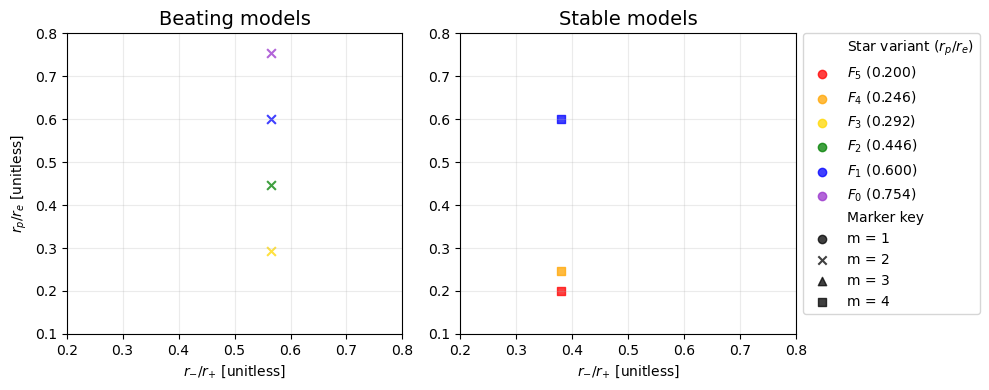

In [24]:
# Subplot to side-by-side cluster plot deploy 
def DF50_Beat_Stbl_sub(df, x_type, y_type, x_label, y_label, title, var, df_type, ax):
    s = 40
    EX = 50
    for index, row in df.iterrows():
        star = row['star']
        x_model = row[x_type]
        y_model = row[y_type]
        marker = int(row['disk_mode'])
        if star == 'F5':
            color = 0
        elif star == 'F4':
            color = 1
        elif star == 'F3':
            color = 2
        elif star == 'F2':
            color = 3
        elif star == 'F1':
            color = 4
        else:
            color = 5
        ax.scatter(x_model, y_model, marker=full_marker_pal[marker-1], s=s, color=full_color_pal[color], alpha=α+ß)    
    tit_suf = {'stab': 'Stable models','beat': 'Beating models'}.get(var, '')
    if var == 'beat':
        ax.set_ylabel(y_label)
        pass
    elif var == 'stab':
        ax.set_ylabel('')
        pass
    ax.set_yticks(np.arange(0.10, 0.9, 0.1))
    ax.set_ylim(0.1, 0.8)
    ax.set_xlim(0.2, 0.8)
    ax.set_title(f"{tit_suf}", fontsize=14)
    ax.set_xlabel(x_label)
    ax.grid(True, alpha=α-ß)

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def DF50_Beat_Stbl_Cluster():
    fig_reset()
    # Create figure
    dial = 5
    font = dial * 2 + 4
    fig, axs = plt.subplots(1, 2, figsize=(dial * 2, dial * 0.8), tight_layout=True)
    ax_beat = axs[0]
    ax_stab = axs[1]
    try:
        # Run Growth Rate plot generator for each i,j,k,l combo
        DF50_Beat_Stbl_sub(df=df_Beating_50, x_type='r-/r+', y_type='rp/re', x_label=r'$r_{-}/r_{+}$ [unitless]', y_label=r'$r_p/r_e$ [unitless]', title='Beating models', var='beat', df_type='beating', ax=ax_beat)
        DF50_Beat_Stbl_sub(df=df_Stable_50, x_type='r-/r+', y_type='rp/re', x_label=r'$r_{-}/r_{+}$ [unitless]', y_label=r'$r_p/r_e$ [unitless]', title='Stable models', var='stab', df_type='stable', ax=ax_stab)
        # Plot legend
        ax_beat.set_ylabel(r'$r_p/r_e$ [unitless]')
        ax_stab.scatter([],[], label=r'Star variant ($r_p/r_e$)', marker="")
        for i, label in enumerate([r'$F_5$ (0.200)', r'$F_4$ (0.246)', r'$F_3$ (0.292)', r'$F_2$ (0.446)', r'$F_1$ (0.600)',r'$F_0$ (0.754)']):
            ax_stab.scatter([],[], label=label, color=full_color_pal[i], alpha=α+ß)
        
        ax_stab.scatter([],[], label='Marker key', marker="")
        for i, label in enumerate(['m = 1', 'm = 2', 'm = 3', 'm = 4']):
            ax_stab.scatter([],[], marker=full_marker_pal[i], color='black', label=label, alpha=α+ß)
        ax_stab.legend(loc='upper left', bbox_to_anchor=(1, 1.024), markerscale=1)
    except Exception as e:
        print(f"Error: {e}")
    # plt.suptitle('Global growth rate not achieved')
    plt.show()

# Thesis used plots
DF50_Beat_Stbl_Cluster()

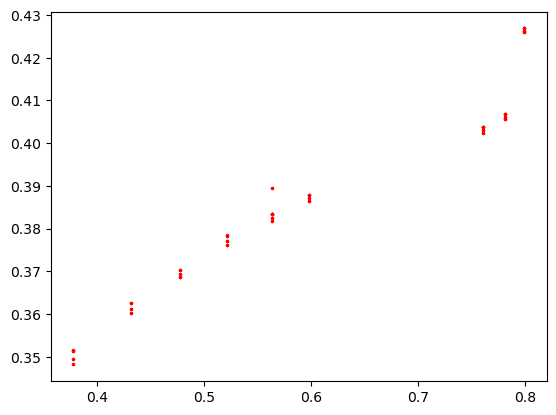

In [25]:
plt.scatter(df_Settled_poly['r-/r+'], df_Settled_poly['T/|W|_disk'], marker=full_marker_pal[0], s=2, color=full_color_pal[0], alpha=α+ß)
plt.show()

try point
pass point
try poly
pass poly


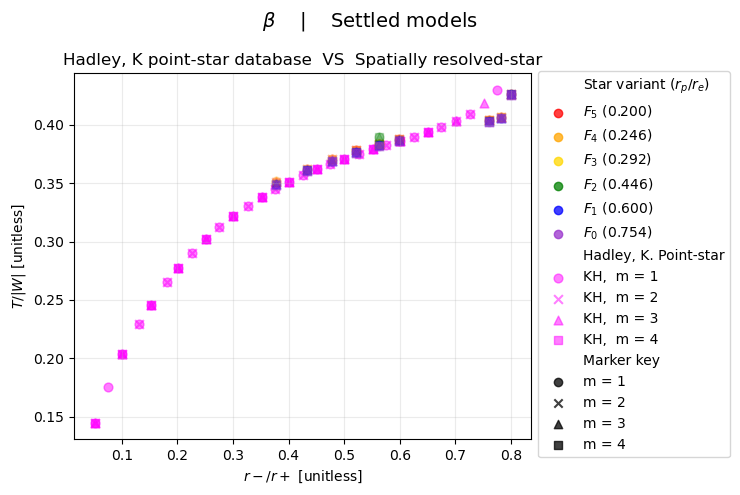

In [26]:
def DF_KH_Plotting_sub(df, x_type, y_type, s, ax):
    # Loop through each unique 'disk_mode' value
    unique_modes = df['disk_mode'].unique()
    for mode in unique_modes:
        # Filter the DataFrame for the current mode
        mode_df = df[df['disk_mode'] == mode]
        ax.scatter(mode_df[x_type], mode_df[y_type], marker=full_marker_pal[mode-1], s=s, alpha=α, label=f'KH,  m = {mode}',color='magenta')

def DF_KH_Indv(df, x_type, y_type):
    dial = 5
    font = dial * 2 + 4
    s = dial*2
    fig, axs = plt.subplots(1, 1, figsize=(dial*1.5, dial), tight_layout=True)
    ax = axs    
    try:
        DF_KH_Plotting_sub(df=df, x_type=x_type, y_type=y_type, s=s, ax=ax)
    except Exception as e:
        print(f"Error: {e}")
    plt.show()

def DF_50_ALT_sub(df, x_type, y_type, ax):
    s = 40
    EX = 50
    for index, row in df.iterrows():
        star = row['star']
        x_model = row[x_type]
        y_model = row[y_type]
        marker = int(row['disk_mode'])
        if star == 'F5':
            color = 0
        elif star == 'F4':
            color = 1
        elif star == 'F3':
            color = 2
        elif star == 'F2':
            color = 3
        elif star == 'F1':
            color = 4
        else:
            color = 5
        ax.scatter(x_model, y_model, marker=full_marker_pal[marker-1], s=s, color=full_color_pal[color], alpha=α+ß)

def DF_poly_ALT_sub(df, x_type, y_type, ax):
    s = 40
    EX = 50
    for index, row in df.iterrows():
        star = row['k_star']
        x_model = row[x_type]
        y_model = row[y_type]
        marker = int(row['disk_mode'])
        if star == 54:
            color = 0
        elif star == 66:
            color = 1
        elif star == 78:
            color = 2
        elif star == 118:
            color = 3
        elif star == 158:
            color = 4
        else:
            color = 5
        ax.scatter(x_model, y_model, marker=full_marker_pal[marker-1], s=s, color=full_color_pal[color], alpha=α-ß)


def DF_KH_Comp(df_KH, df_exp, x_point, y_point, x_exp, y_exp, x_label, y_label, suptit, df_type):
    dial = 5
    font = dial * 2 + 4
    s = dial*8
    fig, ax = plt.subplots(1, 1, figsize=(dial*1.5, dial), tight_layout=True)
    ax.scatter([], [], label=r'Star variant ($r_p/r_e$)', marker="")
    for i, label in enumerate([r'$F_5$ (0.200)', r'$F_4$ (0.246)', r'$F_3$ (0.292)', r'$F_2$ (0.446)', r'$F_1$ (0.600)',r'$F_0$ (0.754)']):
        ax.scatter([], [], label=label, color=full_color_pal[i], alpha=α+ß)
    ax.scatter([], [], label='Hadley, K. Point-star', marker="")
    try:
        print('try point')
        DF_KH_Plotting_sub(df=df_KH, x_type=x_point, y_type=y_point, s=s, ax=ax)
        print('pass point')
        if df_type == '50':
            print('try 50')
            DF_50_ALT_sub(df=df_exp,x_type=x_exp, y_type=y_exp, ax=ax)
            print('pass 50')
        elif df_type == 'poly':
            print('try poly')
            DF_poly_ALT_sub(df=df_exp,x_type=x_exp, y_type=y_exp, ax=ax)
            print('pass poly')
        else:
            print("df_type error, use '50' or 'poly'")
            pass
    except Exception as e:
        print(f"Error: {e}")
    # Print legend labels
    ax.scatter([], [], label='Marker key', marker="")
    for i, label in enumerate(['m = 1', 'm = 2', 'm = 3', 'm = 4']):
        ax.scatter([], [], marker=full_marker_pal[i], color='black', label=label, alpha=α+ß)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.024), markerscale=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True, alpha=α-ß)
    ax.set_title('Hadley, K point-star database  VS  Spatially resolved-star')
    plt.suptitle(f'{suptit}    |    Settled models', fontsize=font)
    plt.show()

# Index(['T/|W|', 'R-/R+', 'jin', 'jmax', 'Y1', 'Y2', 'Rphi/ro', 'Q-/ro',
#        'Q+/ro', 'Rgamma/ro', 'Rilr/ro', 'lindoutAvg', 'Rco/ro', 'R+/ro',
#        'R-/ro', 'Rlambda/ro', 'p', 'sqrtTau', 'Mtorque/Md', 'Jtorque',
#        'radstarMinus', 'radstar', 'radstarPlus', 'disk_mode'],
#       dtype='object')

# Theoretical Polyout columns:  Index(['polytropic index', 'n prime', 'converged after',
#        'relative diff. in hmax', 'relative diff. in h0sq',
#        'relative diff. in c', '1.5*s/|w|', 'T/|W|_star', 'virial error',
#        'axis ratio', 'omega0^2', 'mass', 't', '-w', '3.0*s', 'kd/ks', 'MIRP',
#        'CIRP', 'r-', 'r+', 'ro', 'r-/r+', 'r-/ro', 'r+/ro', 'rs/ro', 'rs/r-',
#        'rp/rs', 'omega_max', 'n', 'np', 'q', 'diskRhomax', 'starRhomax',
#        'j_star', 'k_star', 'j_diskIn', 'j_diskOut', 'logrho_disk', 'starm',
#        'T/|W|_disk', 'Virial_Error_2'],
#       dtype='object')

# Thesis used plots
# DF_KH_Indv(df=df_KH_PointStar, x_type='r-/r+', y_type='T/|W|')#, x_label=r'$r-/r+$ [unitless]', y_label=r'$T/|W|$ [unitless]')
# DF_KH_Comp(df_KH=df_KH_PointStar, df_exp=df_Settled_50, x_type='r-/r+', y_type='T/|W|', x_label=r'$r-/r+$ [unitless]', y_label=r'$T/|W|$ [unitless]', suptit=r'$\beta$')
DF_KH_Comp(df_KH=df_KH_PointStar, df_exp=df_Settled_poly, df_type='poly', x_point='r-/r+', x_exp='r-/r+', y_point='T/|W|', y_exp='T/|W|_disk', x_label=r'$r-/r+$ [unitless]', y_label=r'$T/|W|$ [unitless]', suptit=r'$\beta$')
# DF_KH_Comp(df_KH=df_KH_PointStar, df_exp=df_Settled_50,df_type='50', x_type='r-/r+', y_type='Rco/R0Avg', x_label=r'$r-/r+$ [unitless]', y_label=r'$r_{co}/r_o$ [cell/$r_o$]', suptit=r'Perturbation $r_{co}$ [Normalized to $r_o$]')

In [27]:
# same function as above but for the ployout files without certain missing parameters (compared to fort.50) that are driving the function.
def DFpoly_Plotting(df,x_type,y_type,x_label,y_label,title,star_ratio):
    fig_reset()
    s = 40
    ß = 0.1
    EX = 50
    for index, row in df.iterrows():
        star = row['k_star']
        x_model = row[x_type]
        y_model = row[y_type]
        marker = 1
        if star == '198':
            color = 5
        elif star == '158':
            color = 4
        elif star == '118':
            color = 3
        elif star == '78':
            color = 2
        elif star == '66':
            color = 1
        else:
            color = 0
        plt.scatter(x_model, y_model, marker=full_marker_pal[marker-1], s=s, color=full_color_pal[color],alpha=α+ß)
        if star_ratio == 'yes':
            y_star_rat = float(row['k_star']/row['j_star'])            
            plt.scatter(x_model, y_star_rat, marker='*', s=s, color='black')
        else:
            pass
    y_max = float(df[y_type].max())
    y_min = float(df[y_type].min())
    marker_loc = df[x_type].min()
    if star_ratio == 'yes':
        plt.scatter(marker_loc,y_max*EX,label=r'$r_{\mathrm{p}}/r_{\mathrm{e}}$', marker='*',color='black')
    else:
        pass
    plt.scatter(marker_loc,y_max*EX,label='Color Key', marker="")
    plt.scatter(marker_loc,y_max*EX,label='F0',color=full_color_pal[0],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F1',color=full_color_pal[1],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F2',color=full_color_pal[2],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F3',color=full_color_pal[3],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F4',color=full_color_pal[4],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F5',color=full_color_pal[5],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='Marker Key', marker="")
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[0],color='black',label='m = 1',alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[1],color='black',label='m = 2',alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[2],color='black',label='m = 3',alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[3],color='black',label='m = 4',alpha=α+ß)
    plt.legend(bbox_to_anchor=(1, 1.028), markerscale=1)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    if star_ratio == 'yes':
        plt.ylim(0,0.85)
    else:
        plt.ylim(y_min*0.95,y_max*1.05)
        pass
    plt.grid(True,alpha=α-ß)
    plt.show()

def DFpoly_Plotting2(df,x_type,y_type,x_label,y_label,title,star_ratio):
    fig_reset()
    s = 40
    ß = 0.1
    EX = 50
    for index, row in df.iterrows():
        star = row['k_star']
        x_model = row[x_type]
        y_model = row[y_type]
        marker = 1
        if star == '198':
            color = 5
        elif star == '158':
            color = 4
        elif star == '118':
            color = 3
        elif star == '78':
            color = 2
        elif star == '66':
            color = 1
        else:
            color = 0
        plt.scatter(x_model, y_model, marker=full_marker_pal[marker-1], s=s, color=full_color_pal[color],alpha=α+ß)
        if star_ratio == 'yes':
            y_star_rat = float(row['k_star']/row['j_star'])            
            plt.scatter(x_model, y_star_rat, marker='*', s=s, color='black')
        else:
            pass
    y_max = float(df[y_type].max())
    y_min = float(df[y_type].min())
    marker_loc = df[x_type].min()
    if star_ratio == 'yes':
        plt.scatter(marker_loc,y_max*EX,label=r'$r_{\mathrm{p}}/r_{\mathrm{e}}$', marker='*',color='black')
    else:
        pass
    plt.scatter(marker_loc,y_max*EX,label='Color Key', marker="")
    plt.scatter(marker_loc,y_max*EX,label='F0',color=full_color_pal[0],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F1',color=full_color_pal[1],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F2',color=full_color_pal[2],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F3',color=full_color_pal[3],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F4',color=full_color_pal[4],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='F5',color=full_color_pal[5],alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,label='Marker Key', marker="")
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[0],color='black',label='m = 1',alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[1],color='black',label='m = 2',alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[2],color='black',label='m = 3',alpha=α+ß)
    plt.scatter(marker_loc,y_max*EX,marker=full_marker_pal[3],color='black',label='m = 4',alpha=α+ß)
    plt.legend(bbox_to_anchor=(1, 1.028), markerscale=1)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    if star_ratio == 'yes':
        plt.ylim(0,0.85)
    else:
        plt.ylim(y_min*0.95,y_max*1.05)
        pass
    plt.grid(True,alpha=α-ß)
    plt.show()


# DFpoly_Plotting2(df=df_Settled_poly,x_type='r-/r+',y_type='logrho_disk',x_label=r'Star variant ($r_p/r_e$)',y_label=r'$\log{\rho}$ [unitless]',title='Settled Models',star_ratio='no')     #   'r-/r+'     'disk'      'star'
# DFpoly_Plotting(df=df_Settled_poly,x_type='r-/r+',y_type='T/|W|_star',x_label=r'Star variant ($r_p/r_e$)',y_label=r'$\beta = T/|W|$ [unitless]',title='Settled Models',star_ratio='no')     #   'r-/r+'     'disk'      'star'
# DFpoly_Plotting(df=df_Settled_poly,x_type='r-/r+',y_type='T/|W|_star',x_label='r-/r+ [unitless]',y_label=r'$T/|W|$ [unitless]',title=r'Settled Models   |   $\beta$ vs r-/r+',star_ratio='no')     #   'r-/r+'     'disk'      'star'


Calculate Error

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


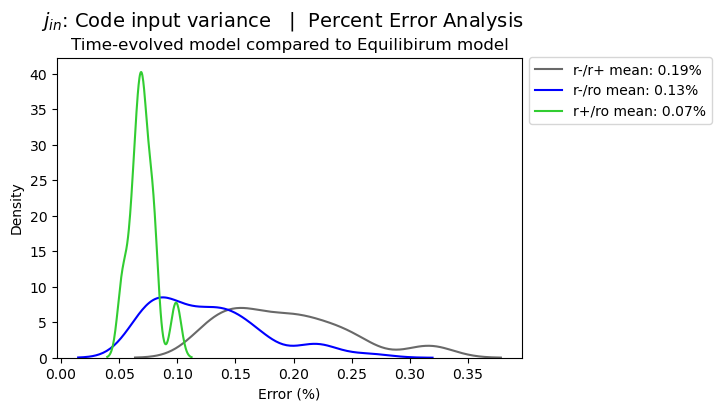

In [28]:
# Standard experimental error calculation
def Exp_Error(exp_val, ther_val):
    err_val = ((ther_val - exp_val) / exp_val) * 100
    return np.abs(err_val)

def Exp_Error_Plot_viables(df_exp, df_ther, val_exp, val_ther):
    plt.figure(figsize=(6, 4))
    plt.suptitle(r'$j_{in}$: Code input variance   |  Percent Error Analysis', fontsize=14)
    ax = plt.gca()  # Get the current Axes instance
    for i in range(len(val_exp)):
        exp_entry = df_exp[val_exp[i]]
        ther_entry = df_ther[val_ther[i]]
        err_err = Exp_Error(exp_val=exp_entry, ther_val=ther_entry)
        label = round(err_err.mean(), 2)
        sns.kdeplot(err_err, label=f'{val_exp[i]} mean: {label}%', color=full_color_pal_disk[i])
    ax.legend(bbox_to_anchor=(1, 1.025), loc='upper left')
    plt.subplots_adjust(top=0.86)  # Adjust space for the suptitle
    ax.set_title('Time-evolved model compared to Equilibirum model')
    ax.set_xlabel('Error (%)')
    plt.show()

# Histogram Plot of error variance
def Exp_Error_Plot(df_exp, df_ther, val_exp, val_ther):
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 4))  # Increase figsize for better visualization
    full_color_pal_disk = ['blue', 'orange', 'green', 'red']  # Example color palette
    # plt.suptitle('Error Analysis',fontsize=20)
    for i in range(len(val_exp)):
        exp_entry = df_exp[val_exp[i]]
        ther_entry = df_ther[val_ther[i]]
        err_err = Exp_Error(exp_val=exp_entry, ther_val=ther_entry)
        if err_err.mean() <= 10.0:
            ax = axs[0]
        else:
            ax = axs[1]
        label = round(err_err.mean(), 2)
        kdeplot = sns.kdeplot(err_err, label=f'{val_exp[i]}  mean: {label}%', color=full_color_pal_disk[i],ax=ax)
    axs[0].legend(bbox_to_anchor=(1, 1.025), loc='upper left')
    axs[1].legend(bbox_to_anchor=(1, 1.025), loc='upper left')
    axs[0].set_title('Percent Error Analysis')  # Use set_title instead of title
    axs[1].set_title('Unviable')  # Use set_title instead of title
    axs[0].set_xlabel('Error (%)')  # Use set_xlabel instead of xlabel
    axs[1].set_xlabel('Error (%)')  # Use set_xlabel instead of xlabel
    plt.show()

# Errors    (Match the exp & ther index to cross compare)
err_option_exp = ['r-/r+','r-/ro','r+/ro']
err_option_ther = ['r-/r+','r-/ro','r+/ro']
# Exp_Error_Plot(df_exp=df_Settled_50,df_ther=df_Settled_poly,val_exp=err_option_exp,val_ther=err_option_ther)

Exp_Error_Plot_viables(df_exp=df_Settled_50,df_ther=df_Settled_poly,val_exp=err_option_exp,val_ther=err_option_ther)


Growth Rates

In [29]:
# Single - Disk Growth Rates History - Individual model
def GwRt_History_Disk_3_sub(model_type,model_star,model_disk,model_m,ax,font,stack):
    font=font
    col_name_23=['MIRP_23', 'D_gr_inner', 'S_gr_inner', 'D_gr_middle', 'S_gr_middle', 'D_gr_outer', 'S_gr_outer']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.23'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_23'])
    D_gr_in = jnp.array(data['D_gr_inner'])
    D_gr_mid = jnp.array(data['D_gr_middle'])
    D_gr_out = jnp.array(data['D_gr_outer'])
    # Plot Disk Growth Rates VS MIRP
    ax.plot(MIRP_23,D_gr_in, linewidth=line_width, color=color_in, label='Inner edge')
    ax.plot(MIRP_23,D_gr_mid, linewidth=line_width, color=color_mid, label='Middle')
    ax.plot(MIRP_23,D_gr_out, linewidth=line_width, color=color_out, label='Outer edge')
    if stack == 'yes':
        ax.set_title(f'Sampled from Disk  |  m={model_m}',fontsize=font)
    else:
        ax.set_title('Sampled from Disk',fontsize=font)
    ax.set_xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    # ax.set_ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    ax.set_yscale("log")
    ax.grid(True,alpha=α)
    ax.legend(loc='lower right')

# Single - Disk Growth Rates History - Individual model
def GwRt_History_Star_3_sub(model_type,model_star,model_disk,model_m,ax,font,stack):
    font=font
    col_name_23=['MIRP_22', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.22'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_22'])
    S_gr_in = jnp.array(data['S_gr_inner_amp'])
    S_gr_mid = jnp.array(data['S_gr_middle_amp'])
    S_gr_out = jnp.array(data['S_gr_outer_amp'])
    # Plot Disk Growth Rates VS MIRP
    ax.plot(MIRP_23,S_gr_in, linewidth=line_width, color=color_in, label='Center')
    ax.plot(MIRP_23,S_gr_mid, linewidth=line_width, color=color_mid, label='Middle')
    ax.plot(MIRP_23,S_gr_out, linewidth=line_width, color=color_out, label='Outer edge')
    if stack == 'yes':
        ax.set_title(f'Sampled from Star  |  m={model_m}',fontsize=font)
    else:
        ax.set_title(r'Sampled from Star',fontsize=font)
    ax.set_xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    ax.set_ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    ax.set_yscale("log")
    ax.grid(True,alpha=α)
    ax.legend(loc='lower right')

# Part of cluster that deploys Star and Disk sub 3 version
def GwRt_History_Combo_3_sub(model_type,model_star,model_disk,model_m,ax,font):
    GwRt_History_Disk_3_sub(model_type=model_type,model_disk=model_disk, model_star=model_star, model_m=model_m,ax=ax,font=font)
    GwRt_History_Star_3_sub(model_type=model_type,model_disk=model_disk, model_star=model_star, model_m=model_m,ax=ax,font=font)
    ax.set_title(r'Combined Star & Disk')
    ax.set_xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    ax.set_ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    ax.set_yscale("log")
    ax.grid(True,alpha=α)
    ax.legend(loc='lower right')                          

# Single - Disk Growth Rates History - Average
def GwRt_History_Star_Avg_sub(model_type,model_star,model_disk,model_m,ax,font):
    font=font
    # Model color determined by model mode
    model_color = full_color_pal[7]
    # Define data column names from Fort.23 file
    col_name_23=['MIRP_22', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.22'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_22'])
    S_gr_in = jnp.array(data['S_gr_inner_amp'])
    S_gr_mid = jnp.array(data['S_gr_middle_amp'])
    S_gr_out = jnp.array(data['S_gr_outer_amp'])
    # Average Growth Rate
    S_gr_avg = (S_gr_in + S_gr_mid + S_gr_out)/3
    # Plot Disk Growth Rates VS MIRP
    ax.plot(MIRP_23,S_gr_avg, linewidth=line_width, color=model_color, label='Star',alpha=α+ß)
    ax.set_xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    # ax.set_ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    ax.set_yscale("log")

# Single - Disk Growth Rates History - Average
def GwRt_History_Disk_Avg_sub(model_type,model_star,model_disk,model_m,ax,font):
    font=font
    # Model color determined by model mode
    model_color = full_color_pal[5]
    # Define data column names from Fort.23 file
    col_name_23=['MIRP_23', 'D_gr_inner', 'S_gr_inner', 'D_gr_middle', 'S_gr_middle', 'D_gr_outer', 'S_gr_outer']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.23'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_23'])
    D_gr_in = jnp.array(data['D_gr_inner'])
    D_gr_mid = jnp.array(data['D_gr_middle'])
    D_gr_out = jnp.array(data['D_gr_outer'])
    # Average Growth Rate
    D_gr_avg = (D_gr_in + D_gr_mid + D_gr_out)/3
    # Plot Disk Growth Rates VS MIRP
    ax.plot(MIRP_23,D_gr_avg, linewidth=line_width, color=model_color, label='Disk',alpha=α+ß)
    ax.set_xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    # ax.set_ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    ax.set_yscale("log")

# Part of cluster that deploys Star and Disk sub avg version
def GwRt_History_Avg_sub(model_type,model_star,model_disk,model_m,ax,font,stack):
    GwRt_History_Star_Avg_sub(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax,font=font)
    GwRt_History_Disk_Avg_sub(model_type=model_type,model_star=model_star,model_disk=model_disk,model_m=model_m,ax=ax,font=font)
    if stack == 'yes':
        ax.set_title(f'Averaged $\omega_g$  |  m={model_m}',fontsize=font)
    else:
        ax.set_title(r'Averaged $\omega_g$',fontsize=font)
    ax.set_xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    # ax.set_ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    ax.set_yscale("log")
    ax.grid(True,alpha=α)
    ax.legend(loc='lower right')

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def GwRt_History_Cluster(group_type,group_star,group_disk,group_m,run_type):
    # Plot visualization parameters
    for i in range(len(group_star)):       
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                # Create figure
                fig_reset()
                dial = 5
                font = dial*2 + 4
                fig, axs = plt.subplots(1,3, figsize=(dial*2,dial*0.8), tight_layout=True)
                ax_star = axs[0]
                ax_disk = axs[1]
                ax_avg = axs[2]
                try:
                    # Run Growth Rate plot generator for each i,j,k,l combo
                    GwRt_History_Disk_3_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_disk,font=font,stack='no')
                    GwRt_History_Star_3_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_star,font=font,stack='no')
                    # GwRt_History_Combo_3_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_combo)
                    GwRt_History_Avg_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_avg,font=font,stack='no')
                except Exception as e:
                    print(f"An error occurred for star {GR_entry_star} model {GR_entry_disk} (M-mode {GR_entry_m}): {e}")
                    continue
                plt.suptitle(f'Temporal Frequency History    |    Star: {GR_entry_star} ,  Disk: {GR_entry_disk} ,  m={GR_entry_m}', fontsize=font+4)
                if run_type == 'save':
                    plt.savefig(f'data/Gen_Img/GwRt_Hist_Avg_{group_type}_{GR_entry_star}_{GR_entry_disk}_m{GR_entry_m}.png')
                elif run_type == 'show':
                    plt.show()

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def GwRt_History_Cluster_Stack(group_type,group_star,group_disk,group_m,run_type):
    # Plot visualization parameters
    fig_reset()
    for i in range(len(group_star)):       
        for j in range(len(group_disk)):
            # Create figure
            dial = 15
            font = dial + 1
            fig, axs = plt.subplots(4,3, figsize=(dial*0.773,dial), tight_layout=True)
            # Populate subplots for each m
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                ax_star = axs[k,0]
                ax_disk = axs[k,1]
                ax_avg = axs[k,2]
                try:
                    # Run Growth Rate plot generator for each i,j,k,l combo
                    GwRt_History_Disk_3_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_disk,font=font-2,stack='yes')
                    GwRt_History_Star_3_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_star,font=font-2,stack='yes')
                    # GwRt_History_Combo_3_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_combo)
                    GwRt_History_Avg_sub(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m,ax=ax_avg,font=font-2,stack='yes')
                except Exception as e:
                    Check_Model(model_star=group_type,model_disk=GR_entry_disk,model_m=GR_entry_m,ax=ax_disk)
                    Check_Model(model_star=group_type,model_disk=GR_entry_disk,model_m=GR_entry_m,ax=ax_star)
                    Check_Model(model_star=group_type,model_disk=GR_entry_disk,model_m=GR_entry_m,ax=ax_avg)
                    print(f"An error occurred for star {GR_entry_star} model {GR_entry_disk} (M-mode {GR_entry_m}): {e}")
                    continue
            plt.suptitle(f'Temporal Frequency History    |    Star: {GR_entry_star} ,  Disk: {GR_entry_disk}', fontsize=font)
            if run_type == 'save':
                plt.savefig(f'data/Gen_Img/GwRt_Hist_Avg_{group_type}_{GR_entry_star}_{GR_entry_disk}.png')
            elif run_type == 'show':
                plt.show()
            plt.close()


# Stack test
# test_star = ['F1']
# test_disk = ['D-Near']
# # GwRt_History_Cluster_Stack(group_type='Beating_Models',group_star=test_star,group_disk=test_disk,group_m=full_group_m,run_type='show')
# GwRt_History_Cluster_Stack(group_type='Stable_Models',group_star=full_group_star,group_disk=test_disk,group_m=full_group_m,run_type='save')

# test_disk = ['E-Mid']
# GwRt_History_Cluster_Stack(group_type='Beating_Models',group_star=full_group_star,group_disk=test_disk,group_m=full_group_m,run_type='save')




# Thesis | Models Used  |   omega_g cluster

# # # GwRt_History_Cluster(group_type='Settled_Models',group_star=full_group_star,group_disk=full_group_disk,group_m=full_group_m,run_type='save')

# # # GwRt_History_Cluster_Stack(group_type='Settled_Models',group_star=full_group_star,group_disk=full_group_disk,group_m=full_group_m,run_type='save')
    #runtime ~2.75 min

# print('Fast')
# test_star = ['F1']
# test_disk = ['D-Far']
# test_m = ['1']
# GwRt_History_Cluster(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m,run_type='show')
# print('Adj')
# test_star = ['F5']
# test_disk = ['E-Far']
# test_m = ['3']
# GwRt_History_Cluster(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m,run_type='save')
# print('Delay')
# test_star = ['F4']
# test_disk = ['D-Near']
# test_m = ['4']
# GwRt_History_Cluster(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m,run_type='save')
# print('Beating')
# test_star = ['F0','F1','F2','F3']
# test_disk = ['E-Mid']
# test_m = ['2']
# GwRt_History_Cluster(group_type='Beating_Models',group_star=test_star,group_disk=test_disk,group_m=test_m,run_type='save')
# print('Stable')
# test_star = ['F1','F5']
# test_disk = ['D-Near']
# test_m = ['4']
# GwRt_History_Cluster(group_type='Stable_Models',group_star=test_star,group_disk=test_disk,group_m=test_m,run_type='save')
# print('Outliers')
# test_star = ['F5']
# test_disk = ['E-Far']
# test_m = ['2']
# GwRt_History_Cluster(group_type='Settled_Models',group_star=full_group_star,group_disk=test_disk,group_m=test_m,run_type='save')
# test_star = ['F1']
# test_disk = ['S-Near']
# test_m = ['4']
# GwRt_History_Cluster(group_type='Settled_Models',group_star=test_star,group_disk=full_group_disk,group_m=test_m,run_type='save')
# test_disk = ['E-Far']
# test_m = ['2']
# GwRt_History_Cluster(group_type='Settled_Models',group_star=full_group_star,group_disk=test_disk,group_m=test_m,run_type='save')
# test_star = ['F4','F5']
# test_disk = ['E-Mid']
# test_m = ['2']
# GwRt_History_Cluster(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m,run_type='save')
# test_star = ['F4',]
# test_disk = ['D-Near']
# test_m = ['4']
# GwRt_History_Cluster(group_type='Stable_Models',group_star=test_star,group_disk=test_disk,group_m=test_m,run_type='save')





In [30]:
# Single - Disk Growth Rates History - Individual model
def GwRt_History_Disk_3(model_type,model_star,model_disk,model_m):
    col_name_23=['MIRP_23', 'D_gr_inner', 'S_gr_inner', 'D_gr_middle', 'S_gr_middle', 'D_gr_outer', 'S_gr_outer']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.23'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_23'])
    D_gr_in = jnp.array(data['D_gr_inner'])
    D_gr_mid = jnp.array(data['D_gr_middle'])
    D_gr_out = jnp.array(data['D_gr_outer'])
    # Plot Disk Growth Rates VS MIRP
    plt.plot(MIRP_23,D_gr_in, linewidth=line_width, color=color_in, label='Inner edge',alpha=α)
    plt.plot(MIRP_23,D_gr_mid, linewidth=line_width, color=color_mid, label='Middle',alpha=α)
    plt.plot(MIRP_23,D_gr_out, linewidth=line_width, color=color_out, label='Outer edge',alpha=α)
    plt.xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    plt.ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    plt.yscale("log")

# Single - Disk Growth Rates History - Individual model
def GwRt_History_Star_3(model_type,model_star,model_disk,model_m):
    col_name_23=['MIRP_22', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.22'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_22'])
    S_gr_in = jnp.array(data['S_gr_inner_amp'])
    S_gr_mid = jnp.array(data['S_gr_middle_amp'])
    S_gr_out = jnp.array(data['S_gr_outer_amp'])
    # Plot Disk Growth Rates VS MIRP
    plt.plot(MIRP_23,S_gr_in, linewidth=line_width, color=color_in, label='Center',alpha=α)
    plt.plot(MIRP_23,S_gr_mid, linewidth=line_width, color=color_mid, label='Middle',alpha=α)
    plt.plot(MIRP_23,S_gr_out, linewidth=line_width, color=color_out, label='Outer edge',alpha=α)
    plt.xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    plt.ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    plt.yscale("log")

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def GwRt_History_Disk_Deploy(group_type,group_star,group_disk,group_m):
    # Plot visualization parameters
    for i in range(len(group_star)):       
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k,l combo
                    GwRt_History_Disk_3(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                    GwRt_History_Star_3(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                except Exception as e:
                    print(f"An error occurred for star {GR_entry_star} model {GR_entry_disk} (M-mode {GR_entry_m}): {e}")
                    continue
                plt.yscale('log')
                plt.legend(loc='lower right')
                plt.suptitle('Sampled Disk Growth Rate History')
                plt.title(f"Star: {GR_entry_star},  Disk: {GR_entry_disk} ,  M-Mode: m={GR_entry_m}")
                plt.grid(True,alpha=α)
                plt.show()

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def GwRt_History_Star_Deploy(group_type,group_star,group_disk,group_m):
    # Plot visualization parameters
    for i in range(len(group_star)):       
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k,l combo
                    GwRt_History_Star_3(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                except Exception as e:
                    print(f"An error occurred for star {GR_entry_star} model {GR_entry_disk} (M-mode {GR_entry_m}): {e}")
                    continue
                plt.yscale('log')
                plt.legend(loc='lower right')
                plt.suptitle('Sampled Star Growth Rate History')
                plt.title(f"Star: {GR_entry_star},  Disk: {GR_entry_disk} ,  M-Mode: m={GR_entry_m}")
                plt.grid(True,alpha=α)
                plt.show()

# Single - Disk Growth Rates History - Average
def GwRt_History_Disk_Avg(model_type,model_star,model_disk,model_m):
    ## Visualiation parameters
    # Line Color logic
    if model_m == '1':
        model_color_pal = 1
    elif model_m == '2':
        model_color_pal = 2
    elif model_m == '3':
        model_color_pal = 3
    elif model_m == '4':
        model_color_pal = 4
    # Model color determined by model mode
    model_color = full_color_pal[model_color_pal]
    # Define data column names from Fort.23 file
    col_name_23=['MIRP_23', 'D_gr_inner', 'S_gr_inner', 'D_gr_middle', 'S_gr_middle', 'D_gr_outer', 'S_gr_outer']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.23'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_23'])
    D_gr_in = jnp.array(data['D_gr_inner'])
    D_gr_mid = jnp.array(data['D_gr_middle'])
    D_gr_out = jnp.array(data['D_gr_outer'])
    # Average Growth Rate
    D_gr_avg = (D_gr_in + D_gr_mid + D_gr_out)/3
    # Plot Disk Growth Rates VS MIRP
    plt.plot(MIRP_23,D_gr_avg, linewidth=line_width, color=model_color, label=f"m = {model_m}")
    plt.xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    plt.ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    plt.yscale("log")

# Group - Disk Growth Rate History - Average
def GwRt_History_Disk_Avg_Deploy(group_type,group_star,group_disk,group_m):
    # Plot visualization parameters
    for i in range(len(group_star)):
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k combo
                    GwRt_History_Disk_Avg(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                except Exception as e:
                    print(f"An error occurred for star {GR_entry_star}, model {GR_entry_disk}, disk mode {GR_entry_m}: {e}")
                    continue
            plt.yscale('log')
            plt.legend()
            plt.suptitle(f'Average Disk Growth Rates of {GR_entry_disk} with star {GR_entry_star}')
            plt.show()


# Interesting models used in Thesis     |   Individual disk and star plots
    # star never settled, could end up like the m=2 or m=3 delayed or adj model
# test_star = ['F0']
# test_disk = ['D-Far']
# test_m = ['4']
# GwRt_History_Disk_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)

# test_star = ['F1']
# test_disk = ['E-Mid']
# test_m = ['2']
# GwRt_History_Disk_Deploy(group_type='Beating_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)

# test_star = ['F1']
# test_disk = ['D-Far']
# test_m = ['1']
# GwRt_History_Star_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)

# test_star = ['F5']
# test_disk = ['E-Far']
# test_m = ['3']
# GwRt_History_Star_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)


In [31]:
# test_star = ['F0']
# test_disk = ['E-Mid']
# test_m = ['2']
# GwRt_History_Disk_Avg_Deploy(group_type='Beating_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)



In [32]:
# Single - Disk Growth Rates History - Individual model
def GwRt_History_Disk_3(model_type,model_star,model_disk,model_m):
    col_name_23=['MIRP_23', 'D_gr_inner', 'S_gr_inner', 'D_gr_middle', 'S_gr_middle', 'D_gr_outer', 'S_gr_outer']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.23'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_23'])
    D_gr_in = jnp.array(data['D_gr_inner'])
    D_gr_mid = jnp.array(data['D_gr_middle'])
    D_gr_out = jnp.array(data['D_gr_outer'])
    # Plot Disk Growth Rates VS MIRP
    plt.plot(MIRP_23,D_gr_in, linewidth=line_width, color=color_in, label='Inner edge')
    plt.plot(MIRP_23,D_gr_mid, linewidth=line_width, color=color_mid, label='Middle')
    plt.plot(MIRP_23,D_gr_out, linewidth=line_width, color=color_out, label='Outer edge')
    plt.xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    plt.ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    plt.yscale("log")

# Single - Disk Growth Rates History - Individual model
def GwRt_History_Star_3(model_type,model_star,model_disk,model_m):
    col_name_23=['MIRP_22', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.22'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_22'])
    S_gr_in = jnp.array(data['S_gr_inner_amp'])
    S_gr_mid = jnp.array(data['S_gr_middle_amp'])
    S_gr_out = jnp.array(data['S_gr_outer_amp'])
    # Plot Disk Growth Rates VS MIRP
    plt.plot(MIRP_23,S_gr_in, linewidth=line_width, color=color_in, label='Center')
    plt.plot(MIRP_23,S_gr_mid, linewidth=line_width, color=color_mid, label='Middle')
    plt.plot(MIRP_23,S_gr_out, linewidth=line_width, color=color_out, label='Outer edge')
    plt.xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    plt.ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    plt.yscale("log")

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def GwRt_History_Disk_Deploy(group_type,group_star,group_disk,group_m):
    # Plot visualization parameters
    for i in range(len(group_star)):       
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k,l combo
                    GwRt_History_Disk_3(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                    GwRt_History_Star_3(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                except Exception as e:
                    print(f"An error occurred for star {GR_entry_star} model {GR_entry_disk} (M-mode {GR_entry_m}): {e}")
                    continue
                plt.yscale('log')
                plt.legend(loc='lower right')
                plt.suptitle('Sampled Disk Growth Rate History')
                plt.title(f"Star: {GR_entry_star},  Disk: {GR_entry_disk} ,  M-Mode: m={GR_entry_m}")
                plt.grid(True,alpha=α)
                plt.show()

# Group - Disk Growth Rate History - Inner, Middle, & Outer
def GwRt_History_Star_Deploy(group_type,group_star,group_disk,group_m):
    # Plot visualization parameters
    for i in range(len(group_star)):       
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k,l combo
                    GwRt_History_Star_3(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                except Exception as e:
                    print(f"An error occurred for star {GR_entry_star} model {GR_entry_disk} (M-mode {GR_entry_m}): {e}")
                    continue
                plt.yscale('log')
                plt.legend(loc='lower right')
                plt.suptitle('Sampled Star Growth Rate History')
                plt.title(f"Star: {GR_entry_star},  Disk: {GR_entry_disk} ,  M-Mode: m={GR_entry_m}")
                plt.grid(True,alpha=α)
                plt.show()

# Single - Disk Growth Rates History - Average
def GwRt_History_Disk_Avg(model_type,model_star,model_disk,model_m):
    ## Visualiation parameters
    # Line Color logic
    if model_m == '1':
        model_color_pal = 1
    elif model_m == '2':
        model_color_pal = 2
    elif model_m == '3':
        model_color_pal = 3
    elif model_m == '4':
        model_color_pal = 4
    # Model color determined by model mode
    model_color = full_color_pal[model_color_pal]
    # Define data column names from Fort.23 file
    col_name_23=['MIRP_23', 'D_gr_inner', 'S_gr_inner', 'D_gr_middle', 'S_gr_middle', 'D_gr_outer', 'S_gr_outer']
    # create file for each i,k,j combo
    file_name_23 = f'data/{model_type}/{model_star}/{model_disk}/m{model_m}/fort.23'
    # Panda Dataframe of each i,k,j combo
    data = pd.read_csv(file_name_23, names=col_name_23, header=None, delimiter=' ')
    # define JAX numpy arrays of data into
    MIRP_23 = jnp.array(data['MIRP_23'])
    D_gr_in = jnp.array(data['D_gr_inner'])
    D_gr_mid = jnp.array(data['D_gr_middle'])
    D_gr_out = jnp.array(data['D_gr_outer'])
    # Average Growth Rate
    D_gr_avg = (D_gr_in + D_gr_mid + D_gr_out)/3
    # Plot Disk Growth Rates VS MIRP
    plt.plot(MIRP_23,D_gr_avg, linewidth=line_width, color=model_color, label=f"m = {model_m}")
    plt.xlabel(r'MIRP [$\rho_o$ revolution time scale]')
    plt.ylabel(r'$\omega_g$ [$MIRP^{-1}$]')
    plt.yscale("log")

# Group - Disk Growth Rate History - Average
def GwRt_History_Disk_Avg_Deploy(group_type,group_star,group_disk,group_m):
    # Plot visualization parameters
    for i in range(len(group_star)):
        for j in range(len(group_disk)):
            for k in range(len(group_m)):
                # Define models parameters
                GR_entry_star = group_star[i]
                GR_entry_disk = group_disk[j]
                GR_entry_m = full_group_m[k]  # Use k for group_m index
                try:
                    # Run Growth Rate plot generator for each i,j,k combo
                    GwRt_History_Disk_Avg(model_type=group_type,model_disk=GR_entry_disk, model_star=GR_entry_star, model_m=GR_entry_m)
                except Exception as e:
                    print(f"An error occurred for star {GR_entry_star}, model {GR_entry_disk}, disk mode {GR_entry_m}: {e}")
                    continue
            plt.yscale('log')
            plt.legend()
            plt.suptitle(f'Average Disk Growth Rates of {GR_entry_disk} with star {GR_entry_star}')
            plt.show()


# Overlaps star and disk omega_g data but is difficult to read. Need to fix colors. Use the cluster plot above.

# test_star = ['F5']
# test_disk = ['E-Far']
# test_m = ['3']
# GwRt_History_Star_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F1']
# test_disk = ['D-Far']
# test_m = ['1']
# GwRt_History_Star_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)

# test_star = ['F1']
# test_disk = ['D-Far']
# test_m = ['1']
# GwRt_History_Disk_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F5']
# test_disk = ['E-Far']
# test_m = ['3']
# GwRt_History_Disk_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F0']
# test_disk = ['D-Far']
# test_m = ['4']
# GwRt_History_Disk_Deploy(group_type='Stable_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F1']
# test_disk = ['E-Mid']
# test_m = ['2']
# GwRt_History_Disk_Deploy(group_type='Beating_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)

In [33]:
# test_star = ['F1']
# test_disk = ['D-Far']
# test_m = ['1']
# GwRt_History_Disk_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F5']
# test_disk = ['E-Far']
# test_m = ['3']
# # GwRt_History_Disk_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F5']
# test_disk = ['E-Far']
# test_m = ['3']
# # GwRt_History_Star_Deploy(group_type='Settled_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F1']
# test_disk = ['E-Mid']
# test_m = ['2']
# # GwRt_History_Disk_Deploy(group_type='Beating_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)
# test_star = ['F1']
# test_disk = ['D-Near']
# test_m = ['4']
# GwRt_History_Disk_Deploy(group_type='Stable_Models',group_star=test_star,group_disk=test_disk,group_m=test_m)


In [34]:
# GwRt_History_Disk_Avg_Deploy(group_type='Settled_Models',group_star=full_group_star,group_disk=full_group_disk,group_m=full_group_m)
# GwRt_History_Disk_Avg_Deploy(group_type='Beating_Models',group_star=full_group_star,group_disk=full_group_disk,group_m=full_group_m)
# GwRt_History_Disk_Avg_Deploy(group_type='Stable_Models',group_star=full_group_star,group_disk=full_group_disk,group_m=full_group_m)
    # Settled Runtime: 32s

In [35]:
# GwRt_Val_disk(df_Settled_50,x_type='r-/r+',y_type='y2avg')     #   'r-/r+'     'disk'      'star'
def GwRt_Val_disk(df,x_type,y_type):
    fig_reset()
    dial = 5
    font = 12
    fig, axs = plt.subplots(figsize=(dial*1.5,dial))
    s = 50
    ß = 0.1
    for index, row in df.iterrows():
        star = row['star']
        x_model = row[x_type]
        y_model = row[y_type]
        marker = int(row['disk_mode'])
        if star == 'F5':
            color = 0
        elif star == 'F4':
            color = 1
        elif star == 'F3':
            color = 2
        elif star == 'F2':
            color = 3
        elif star == 'F1':
            color = 4
        else:
            color = 5
        plt.scatter(x_model, y_model, marker=full_marker_pal[marker-1], s=s, color=full_color_pal[color],alpha=α+ß)
    # Labels
    plt.scatter([],[], label=r'Star variant ($r_p/r_e$)', marker="")
    for i, label in enumerate([r'$F_5$ (0.200)', r'$F_4$ (0.246)', r'$F_3$ (0.292)', r'$F_2$ (0.446)', r'$F_1$ (0.600)',r'$F_0$ (0.754)']):
        plt.scatter([],[], label=label, color=full_color_pal[i], alpha=α+ß)
    
    plt.scatter([],[], label='Marker key', marker="")
    for i, label in enumerate(['m = 1', 'm = 2', 'm = 3', 'm = 4']):
        plt.scatter([],[], marker=full_marker_pal[i], color='black', label=label, alpha=α+ß)

    # plt.scatter(marker_loc,y_max*5,label='Color Key', marker="")
    # plt.scatter(marker_loc,y_max*5,label='F0',color=full_color_pal[0],alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,label='F1',color=full_color_pal[1],alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,label='F2',color=full_color_pal[2],alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,label='F3',color=full_color_pal[3],alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,label='F4',color=full_color_pal[4],alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,label='F5',color=full_color_pal[5],alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,label='Marker Key', marker="")
    # plt.scatter(marker_loc,y_max*5,marker=full_marker_pal[0],color='black',label='m = 1',alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,marker=full_marker_pal[1],color='black',label='m = 2',alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,marker=full_marker_pal[2],color='black',label='m = 3',alpha=α+ß)
    # plt.scatter(marker_loc,y_max*5,marker=full_marker_pal[3],color='black',label='m = 4',alpha=α+ß)
    plt.legend(bbox_to_anchor=(1, 1.028), markerscale=1.25,fontsize=font)
    plt.yticks(ticks=[i/2 for i in range(7)],fontsize=font)
    plt.ylabel(r'Growth Rate [$MIRP^{-1}$]',fontsize=font)
    plt.ylim(0,3)
    plt.xticks(fontsize=font)
    plt.xlabel('r-/r+ [unitless]',fontsize=font)
    plt.grid(True,alpha=α-ß)
    plt.title('Settled models growth rates',fontsize=font+4)
    plt.show()

# Plot Average Disk Growth Rate Value - All Stars (x-axis r-/r+)
def GwRt_Val_rminus_rplus(df): # single star, x:r-/r+, y:growth_rate
    # Define models axis elements
    x_model = df['r-/r+']
    y_model = df['y2avg']
    Mode_1 = df['disk_mode'] == '1'
    Mode_2 = df['disk_mode'] == '2'
    Mode_3 = df['disk_mode'] == '3'
    Mode_4 = df['disk_mode'] == '4'
    plt.scatter(x_model[Mode_1],y_model[Mode_1],marker='o', label='m=1', color=color_by_num[1])
    plt.scatter(x_model[Mode_2],y_model[Mode_2],marker='+', label='m=2', color=color_by_num[2])
    plt.scatter(x_model[Mode_3],y_model[Mode_3],marker='^', label='m=3', color=color_by_num[3])
    plt.scatter(x_model[Mode_4],y_model[Mode_4],marker='s', label='m=4', color=color_by_num[4])
    plt.legend(bbox_to_anchor=(1, 1.021))
    plt.suptitle('Settled Growth Rates VS r-/r+')
    plt.ylabel('Growth Rate')
    plt.xlabel('r-/r+')
    plt.xticks(rotation=30, ha='right')
    plt.show()

# GwRt_Val_rminus_rplus(df)

In [36]:
def Parameter_Space_Plot(z_opt):
    # Create a 3D plot
    plt.ion()   # Make interactive
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot data points
    x_model = df_Settled_50['r-/r+']
    y_model = df_Settled_50['rp/re']
    z_model = df_Settled_50[z_opt]
    ax.scatter(x_model, y_model, z_model, c='r', marker='o')
    # Set labels and title
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Scatter Plot')
    plt.show()

# Parameter_Space_Plot(z_opt='T/|W|')

In [37]:
# Plots all models onto a single plot   # All Stars (marker color)  # All disk modes (marker shape)
def All_Stars_Comb(df,x,y,title,sup_title,x_lab,y_lab):
    for i in range(len(full_group_star)):
        fig_reset()
        star_sel = df['star'] == full_group_star[i]
        # Filter for each disk mode
        disk_mode_sel = df['disk_mode'] == '1'
        disk_mode_sel2 = df['disk_mode'] == '2'
        disk_mode_sel3 = df['disk_mode'] == '3'
        disk_mode_sel4 = df['disk_mode'] == '4'
        plt.scatter(x[disk_mode_sel & star_sel], y[disk_mode_sel & star_sel], c=full_color_pal[i], label=f'{full_group_star[i]}, m=1', marker=full_marker_pal[0])
        plt.scatter(x[disk_mode_sel2 & star_sel], y[disk_mode_sel2 & star_sel], c=full_color_pal[i], label=f'{full_group_star[i]}, m=2', marker=full_marker_pal[1])
        plt.scatter(x[disk_mode_sel3 & star_sel], y[disk_mode_sel3 & star_sel], c=full_color_pal[i], label=f'{full_group_star[i]}, m=3', marker=full_marker_pal[2])
        plt.scatter(x[disk_mode_sel4 & star_sel], y[disk_mode_sel4 & star_sel], c=full_color_pal[i], label=f'{full_group_star[i]}, m=4', marker=full_marker_pal[3])
    plt.legend(bbox_to_anchor=(1.25, 1.02))
    plt.xticks(rotation=30, ha='right')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.suptitle(sup_title)
    plt.title(title)
    plt.show()

# Plots all disk modes of a single star on a plot, for all stars (6 total)  # All Stars (marker color)  # All disk modes (marker shape)
def All_Stars_Indv(df,x,y,sup_title):
    for i in range(len(full_group_star)):
        plt.rcParams.update(plt.rcParamsDefault)
        star_sel = df['star'] == full_group_star[i]
        # Filter for each disk mode
        disk_mode_sel = df['disk_mode'] == '1'
        disk_mode_sel2 = df['disk_mode'] == '2'
        disk_mode_sel3 = df['disk_mode'] == '3'
        disk_mode_sel4 = df['disk_mode'] == '4'
        plt.scatter(x[disk_mode_sel & star_sel], y[disk_mode_sel & star_sel], c=full_color_pal[i], label='m=1', marker=full_marker_pal[0])
        plt.scatter(x[disk_mode_sel2 & star_sel], y[disk_mode_sel2 & star_sel], c=full_color_pal[i], label='m=2', marker=full_marker_pal[1])
        plt.scatter(x[disk_mode_sel3 & star_sel], y[disk_mode_sel3 & star_sel], c=full_color_pal[i], label='m=3', marker=full_marker_pal[2])
        plt.scatter(x[disk_mode_sel4 & star_sel], y[disk_mode_sel4 & star_sel], c=full_color_pal[i], label='m=4', marker=full_marker_pal[3])
        plt.legend(bbox_to_anchor=(1.25, 1.02))
        plt.xticks(rotation=30, ha='right')
        # plt.xlabel(r'$\frac{r_-}{r_+}$')  # Alternate format (small font | hard to read)
        plt.xlabel(r'$r_- / r_+$ [unitless]')
        plt.ylabel('Average disk growth rate [unitless]')
        plt.suptitle(sup_title)
        plt.title(f"for star: {full_group_star[i]}")
        plt.show()


# MCMC

### Apply to Beating models to get approxmate $\omega_g$

#### Finish in MCMC.ipynb

# Legacy Code

### Below this point, pulls values and builds panda dataframes using various fort.*** files
###### Most of the code below has been reworked and applied above in the graph, so there may be some bugged file names after various updates

In [38]:
# # Import Intital Large Gaia dataset
# df = pd.read_csv('..//gaia-NGC6397-neighborhood.csv')

# # Import Windowed Dataset around (265.17,-53.68) with a window of (2°,1.5°)
# C_df = pd.read_fwf("../data/NGC6397-1.dat", colspecs="infer", names=['source_id', 'ra', 'dec', 'pm'], header=None)

# my_sel = df['source_id'].isin(C_df.source_id)
# # print(np.count_nonzero(sf))

# df[my_sel].columns

r-/r+ VS y2avg

###### All models onto one plot

Which model is going to develop fastest?

r-/r+ VS y2avg

###### Each Star model on their own plot

How did each star model perform?

sort by r-/r+ then use disk name labels (show value of r-/r+)
Adjust color to show different datasets

r-/r+ VS ß=T/|W|

###### All models onto one plot

How does the flattening star change ß? (Does the disk change also make an effect?)

fort.50 T/|W| is only for the whole system

Use Polyout (Star / Disk) to get the proper values (from EQ code) for the two separated

kstar/jstar VS ß

###### All models onto one plot

How did the different flat stars affect ß?

ghost cells of 2 need to get adjusted
r_pol* / r_eq*

r-/r+ VS time(cirp)

###### All models onto one plot

How far have each model developed?

time is units of MIRP
time(cirp), go figure is time units of CIRP